In [1]:
# Create folder 
from utils.create_folder import create_simulation_folder
results_dir = create_simulation_folder()

[INFO] Simulation folder created: results/2026-01-05_10-16-48


In [2]:
from milp.solve_gurobi_shrink_until_feasible import (
    solve_gurobi_shrink_until_feasible,
    build_multi_slice_model,
)

ImportError: cannot import name 'solve_gurobi_sequential' from 'milp.solve_gurobi_sequential' (/home/cecilia/5g-slicing-energy-effiiciency/simulator/milp/solve_gurobi_sequential.py)

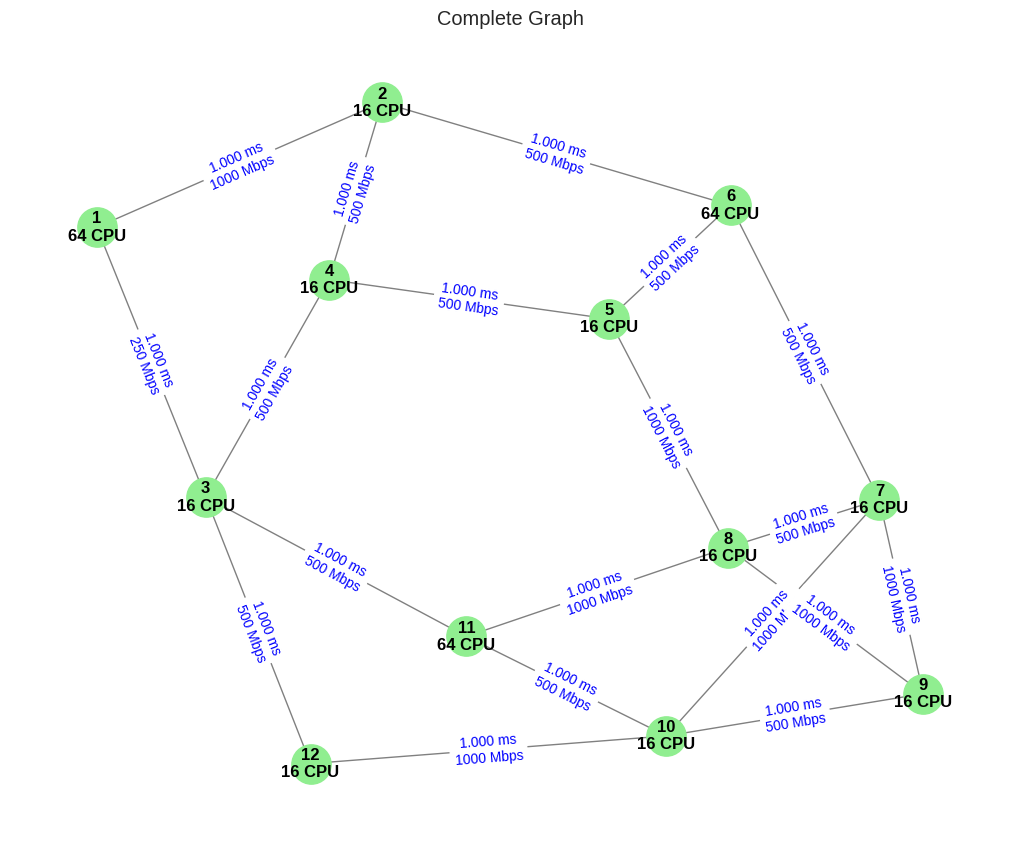

In [9]:
from utils.topology import topology_bayern, draw_graph, topologie_finlande, topology_brazil
from utils.generate_slices import generate_random_slices
from milp.topology_to_instance import build_instance_from_topology
from milp.solver_gurobi import solve_gurobi      
from milp.adapter import MILPResultAdapterGurobi, MILPSequentialAdapter

import pandas as pd

# === Topology ===
G = topologie_finlande()

draw_graph(G)


In [10]:
# ============================
# Imports (clean and complete)
# ============================

import os
import time
import random
import numpy as np
import networkx as nx
import pandas as pd
from copy import deepcopy
from datetime import datetime
import re

from itertools import product
from tqdm import tqdm


# --- Safe filename function ---
def safe_filename(text):
    """Convert any string into a safe filename: no accents, spaces, or special chars."""
    text = text.lower()
    text = text.replace(" ", "_")
    text = re.sub(r"[^a-z0-9_\-]", "", text)
    return text

# --- Global reproducibility seed ---
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
os.environ["PYTHONHASHSEED"] = str(GLOBAL_SEED)

# --- MILP sequential modules ---
from milp.create_instance import create_instance
from milp.solve_gurobi_sequential import (
    solve_gurobi_sequential,
    _get_slice_vl_pairs,
    NODE_ENERGY_WEIGHT,
    LINK_ENERGY_WEIGHT,
)

# --- Topologies ---
from utils.topology import topologie_finlande, topology_brazil

# --- Slice generation ---
from utils.generate_slices import generate_random_slices

# --- Graph generation ---
from utils.generate_graphs import plot_all_routes, plot_cpu_usage

# --- Heuristics ---
from heuristics.a_star import run_astar
from heuristics.run_abo_full_batch import run_abo_full_batch
from heuristics.run_fabo_full_batch import run_fabo_full_batch
from heuristics.best_fit import run_best_fit
from heuristics.first_fit import run_first_fit
from heuristics.a_star_energy_aware import energy_aware_astar

# --- Metrics ---
from utils.metrics import (
    count_accepted_slices,
    compute_energy_new,
    compute_total_bandwidth,
    compute_total_latency,
)

# ============================
# Helper: energy for sequential MILP
# ============================

def compute_seq_milp_energy(instance, seq_result):
    """Compute total node/link energy for the sequential MILP result."""
    total_E_nodes = 0.0
    total_E_links = 0.0

    for s in seq_result["accepted_slices"]:
        res_s = seq_result["slice_results"][s]
        N = instance.N
        E = instance.E
        vl_pairs = _get_slice_vl_pairs(instance, s)

        # Node energy
        node_terms = []
        for n in N:
            cpu_used_n = 0.0
            for i in instance.V_of_s[s]:
                x_val = res_s.values.get(("x", s, i, n), 0.0)
                cpu_used_n += instance.CPU_i[i] * x_val
            cap_n = instance.CPU_cap[n]
            if cap_n > 0:
                node_terms.append(cpu_used_n / cap_n)
        E_nodes_s = NODE_ENERGY_WEIGHT * sum(node_terms)

        # Link energy
        link_terms = []
        for (u, v) in E:
            bw_used_uv = 0.0
            for (i, j) in vl_pairs:
                f_val = res_s.values.get(("f", s, i, j, u, v), 0.0)
                bw_used_uv += f_val
            cap_uv = instance.BW_cap[(u, v)]
            if cap_uv > 0:
                link_terms.append(bw_used_uv / cap_uv)
        E_links_s = LINK_ENERGY_WEIGHT * sum(link_terms)

        total_E_nodes += E_nodes_s
        total_E_links += E_links_s

    return total_E_nodes, total_E_links, (total_E_nodes + total_E_links)

# ============================
# Directories for results
# ============================

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_dir = os.path.join("./results", safe_filename(timestamp))
os.makedirs(results_dir, exist_ok=True)

routes_dir = os.path.join(results_dir, "routes")
cpu_dir = os.path.join(results_dir, "cpu_usage")
os.makedirs(routes_dir, exist_ok=True)
os.makedirs(cpu_dir, exist_ok=True)

print(f"[INFO] Results will be saved under: {results_dir}")

# ============================
# Global experiment parameters
# ============================

MILP_TIME_LIMIT = 300
ENTRY = 6
MAX_MILP_SLICES = 128
MAX_MILP_VNFS_TOTAL = 512

ENABLE_PLOTS = True          # deixe False se quiser só CSV
ENABLE_SEQ_MILP = True       # deixe False se não quiser MILP sequencial

# --- Topology ---
G = topologie_finlande()
ENTRY = 6
pos = nx.spring_layout(G, seed=GLOBAL_SEED)

# --- VNF profiles ---
vnf_profiles = [
    {"cpu": 2,  "throughput": 30, "latency": 80},   # light
    {"cpu": 3,  "throughput": 40, "latency": 110},  # slightly heavier
    {"cpu": 4,  "throughput": 50, "latency": 140},  # medium
    {"cpu": 6,  "throughput": 65, "latency": 180},  # medium-heavy
    {"cpu": 8,  "throughput": 80, "latency": 220},  # heavy
    {"cpu": 10, "throughput": 95, "latency": 260},  # very heavy
]

# --- Base capacities ---
node_capacity_base = {n: G.nodes[n]["cpu"] for n in G.nodes}
link_capacity_base = {(u, v): G[u][v]["bandwidth"] for u, v in G.edges}
link_capacity_base.update({(v, u): G[u][v]["bandwidth"] for u, v in G.edges})
link_latency = {(u, v): G[u][v]["latency"] for u, v in G.edges}
link_latency.update({(v, u): G[u][v]["latency"] for u, v in G.edges})

# --- Parameter grid (seeds 1 a 5) ---
param_grid = {
    "num_slices": [8, 16, 32, 64, 128],
    "num_vnfs_per_slice": [2, 3, 4, 5, 6],
    "seed": list(range(1, 6)),  # 1..5
}

max_slices = max(param_grid["num_slices"])

# Lista de todos os cenários (num_vnfs, seed, num_slices)
scenario_list = list(product(
    param_grid["num_vnfs_per_slice"],
    param_grid["seed"],
    param_grid["num_slices"],
))
total_scenarios = len(scenario_list)
print(f"[INFO] Total scenarios: {total_scenarios}")

# Pré-gerar pools de slices por (num_vnfs, seed)
slice_pools = {}
for num_vnfs in param_grid["num_vnfs_per_slice"]:
    for seed in param_grid["seed"]:
        random.seed(seed)
        np.random.seed(seed)
        print(f"\n[INFO] === Pre-generating slice pool: max_slices={max_slices}, "
              f"VNFs={num_vnfs}, seed={seed} ===")

        slice_pool = generate_random_slices(
            G,
            vnf_profiles,
            num_slices=max_slices,
            num_vnfs_per_slice=num_vnfs,
            entry=ENTRY,
        )
        slice_pools[(num_vnfs, seed)] = slice_pool

# ============================
# Main experiment loop
# ============================

records = []

try:
    pbar = tqdm(total=total_scenarios, desc="Scenarios", unit="scenario")

    for (num_vnfs, seed, num_slices) in scenario_list:
        total_vnfs = num_slices * num_vnfs

        pbar.set_description(
            f"Scen: vnfs={num_vnfs}, seed={seed}, slices={num_slices}"
        )

        slice_pool = slice_pools[(num_vnfs, seed)]

        print(f"\n[INFO] === Running Load Test: {num_slices} slices × "
              f"{num_vnfs} VNFs (total={total_vnfs}), seed={seed} ===")

        slices = deepcopy(slice_pool[:num_slices])
        method_results = {}
        method_times = {}

        # --- Heurísticas ---
        heuristics_spec = [
            ("A*",            run_astar,          (G, slices, node_capacity_base, link_capacity_base)),
            ("ABO",           run_abo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
            ("FABO",          run_fabo_full_batch,(G, slices, node_capacity_base, link_latency, link_capacity_base)),
            ("Best Fit",      run_best_fit,       (G, slices, node_capacity_base, link_capacity_base, link_latency)),
            ("First Fit",     run_first_fit,      (G, slices, node_capacity_base, link_capacity_base, link_latency)),
            ("Energy-Aware A*", energy_aware_astar,
                                (G, slices, node_capacity_base, link_capacity_base, 0.6, 0.4)),
        ]

        for name, func, args in heuristics_spec:
            start = time.time()
            try:
                df_res, res_list = func(*args)
                method_results[name] = res_list
            except Exception as e:
                print(f"[ERROR] {name} failed: {e}")
                method_results[name] = []
            method_times[name] = time.time() - start

        # --- MILP sequencial opcional ---
        if ENABLE_SEQ_MILP and num_slices <= MAX_MILP_SLICES and total_vnfs <= MAX_MILP_VNFS_TOTAL:
            try:
                print(f"\n[INFO][MILP-SEQ] Running Sequential MILP…")
                start = time.time()

                instance = create_instance(G, slices)
                instance.entry_node = ENTRY

                seq_res = solve_gurobi_sequential(
                    instance,
                    msg=False,
                    time_limit=MILP_TIME_LIMIT,
                )
                milp_seq_runtime = time.time() - start


                accepted_seq = len(seq_res["accepted_slices"])
                E_nodes_seq, E_links_seq, E_total_seq = compute_seq_milp_energy(
                    instance, seq_res
                )

                records.append({
                    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    "num_slices": num_slices,
                    "num_vnfs_per_slice": num_vnfs,
                    "total_vnfs": total_vnfs,
                    "seed": seed,
                    "method": "MILP_Sequential",
                    "accepted": accepted_seq,
                    "total_energy": E_total_seq,
                    "total_bandwidth": None,
                    "total_latency": None,
                    "runtime_sec": milp_seq_runtime,
                })
            except Exception as e:
                print(f"[ERROR][MILP-SEQ] Failed: {e}")

        # --- Plots por cenário (opcional) ---
        if ENABLE_PLOTS:
            for method_name, result_list in method_results.items():
                if not result_list:
                    continue

                safe_img_name = safe_filename(
                    f"{method_name}_slices{num_slices}_vnfs{num_vnfs}_seed{seed}"
                )

                plot_all_routes(
                    G,
                    result_list,
                    title="All routed paths",
                    results_dir=routes_dir,
                    num_slices=num_slices,
                    num_vnfs_per_slice=num_vnfs,
                    seed=seed,
                    method_name=safe_img_name,
                    # pos=pos,  # descomente se a função aceitar layout fixo
                )

            plot_cpu_usage(
                G,
                slices,
                method_results,
                results_dir=cpu_dir,
                num_slices=num_slices,
                num_vnfs_per_slice=num_vnfs,
                seed=seed,
            )

        # --- Métricas para heurísticas ---
        for method_name, result_list in method_results.items():
            if not result_list:
                continue
            try:
                accepted = count_accepted_slices(result_list, slices)
                total_energy = compute_energy_new(
                    result_list, slices, node_capacity_base, link_capacity_base
                )
                total_bw = sum(b for b in compute_total_bandwidth(result_list, slices) if b)
                total_lat = sum(l for l in compute_total_latency(result_list, link_latency) if l)

                records.append({
                    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    "num_slices": num_slices,
                    "num_vnfs_per_slice": num_vnfs,
                    "total_vnfs": total_vnfs,
                    "seed": seed,
                    "method": method_name,
                    "accepted": accepted,
                    "total_energy": total_energy,
                    "total_bandwidth": total_bw,
                    "total_latency": total_lat,
                    "runtime_sec": method_times[method_name],
                })
            except Exception as e:
                print(f"[ERROR] Metrics failed for {method_name}, "
                      f"slices={num_slices}, vnfs={num_vnfs}, seed={seed}: {e}")

        # atualiza progress bar ao final de cada cenário
        pbar.update(1)

finally:
    try:
        pbar.close()
    except:
        pass

    df_results = pd.DataFrame(records)

    if not df_results.empty:
        dup = df_results.groupby(["method", "num_slices", "num_vnfs_per_slice", "seed"]).size()
        print("[CHECK] Max repetitions:", dup.max())
    else:
        print("[WARN] df_results is empty, nothing to group.")

    output_path = os.path.join(results_dir, "scalability_results.csv")
    df_results.to_csv(output_path, index=False)
    print(f"\n[INFO] Results saved to {output_path}")
    print(f"[INFO] records generated: {len(records)}")
    print(f"[INFO] CSV exists? {os.path.exists(output_path)}")


[INFO] Results will be saved under: ./results/2025-12-15_09-06-32
[INFO] Total scenarios: 125

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=2, seed=1 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=2, seed=2 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=2, seed=3 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=2, seed=4 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=2, seed=5 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=3, seed=1 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=3, seed=2 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=3, seed=3 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=3, seed=4 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=3, seed=5 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=4, seed=1 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=4, seed=2 ===

[INFO] === Pre-ge

Scen: vnfs=2, seed=1, slices=8:   0%|          | 0/125 [00:00<?, ?scenario/s]


[INFO] === Running Load Test: 8 slices × 2 VNFs (total=16), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 7 accepted.


[INFO][A*]

Scen: vnfs=2, seed=1, slices=8:   0%|          | 0/125 [00:01<?, ?scenario/s]


[WARN] df_results is empty, nothing to group.

[INFO] Results saved to ./results/2025-12-15_09-06-32/scalability_results.csv
[INFO] records generated: 0
[INFO] CSV exists? True


KeyboardInterrupt: 

In [ ]:
# ============================
# Imports (clean and complete)
# ============================

import os
import time
import random
import numpy as np
import networkx as nx
import pandas as pd
from copy import deepcopy
from datetime import datetime
import re

from itertools import product
from tqdm import tqdm


# --- Safe filename function ---
def safe_filename(text):
    """Convert any string into a safe filename: no accents, spaces, or special chars."""
    text = text.lower()
    text = text.replace(" ", "_")
    text = re.sub(r"[^a-z0-9_\-]", "", text)
    return text

# --- Global reproducibility seed ---
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
os.environ["PYTHONHASHSEED"] = str(GLOBAL_SEED)

# --- MILP sequential modules ---
from milp.create_instance import create_instance
from milp.solve_gurobi_sequential import (
    solve_gurobi_sequential,
    _get_slice_vl_pairs,
    NODE_ENERGY_WEIGHT,
    LINK_ENERGY_WEIGHT,
)

# --- Topologies ---
from utils.topology import topologie_finlande, topology_brazil

# --- Slice generation ---
from utils.generate_slices import generate_random_slices

# --- Graph generation ---
from utils.generate_graphs import plot_all_routes, plot_cpu_usage

# --- Heuristics ---
from heuristics.a_star import run_astar
from heuristics.run_abo_full_batch import run_abo_full_batch
from heuristics.run_fabo_full_batch import run_fabo_full_batch
from heuristics.best_fit import run_best_fit
from heuristics.first_fit import run_first_fit
from heuristics.a_star_energy_aware import energy_aware_astar

# --- Metrics ---
from utils.metrics import (
    count_accepted_slices,
    compute_energy_new,
    compute_total_bandwidth,
    compute_total_latency,
)

# ============================
# Helper: energy for sequential MILP
# ============================

def compute_seq_milp_energy(instance, seq_result):
    """Compute total node/link energy for the sequential MILP result."""
    total_E_nodes = 0.0
    total_E_links = 0.0

    for s in seq_result["accepted_slices"]:
        res_s = seq_result["slice_results"][s]
        N = instance.N
        E = instance.E
        vl_pairs = _get_slice_vl_pairs(instance, s)

        # Node energy
        node_terms = []
        for n in N:
            cpu_used_n = 0.0
            for i in instance.V_of_s[s]:
                x_val = res_s.values.get(("x", s, i, n), 0.0)
                cpu_used_n += instance.CPU_i[i] * x_val
            cap_n = instance.CPU_cap[n]
            if cap_n > 0:
                node_terms.append(cpu_used_n / cap_n)
        E_nodes_s = NODE_ENERGY_WEIGHT * sum(node_terms)

        # Link energy
        link_terms = []
        for (u, v) in E:
            bw_used_uv = 0.0
            for (i, j) in vl_pairs:
                f_val = res_s.values.get(("f", s, i, j, u, v), 0.0)
                bw_used_uv += f_val
            cap_uv = instance.BW_cap[(u, v)]
            if cap_uv > 0:
                link_terms.append(bw_used_uv / cap_uv)
        E_links_s = LINK_ENERGY_WEIGHT * sum(link_terms)

        total_E_nodes += E_nodes_s
        total_E_links += E_links_s

    return total_E_nodes, total_E_links, (total_E_nodes + total_E_links)

# ============================
# Directories for results
# ============================

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_dir = os.path.join("./results", safe_filename(timestamp))
os.makedirs(results_dir, exist_ok=True)

routes_dir = os.path.join(results_dir, "routes")
cpu_dir = os.path.join(results_dir, "cpu_usage")
os.makedirs(routes_dir, exist_ok=True)
os.makedirs(cpu_dir, exist_ok=True)

print(f"[INFO] Results will be saved under: {results_dir}")

# ============================
# Global experiment parameters
# ============================

MILP_TIME_LIMIT = 300
ENTRY = 6
MAX_MILP_SLICES = 128
MAX_MILP_VNFS_TOTAL = 512

ENABLE_PLOTS = True          # deixe False se quiser só CSV
ENABLE_SEQ_MILP = True       # deixe False se não quiser MILP sequencial

# --- Topology ---
G = topologie_finlande()
ENTRY = 6
pos = nx.spring_layout(G, seed=GLOBAL_SEED)

# --- VNF profiles ---
vnf_profiles = [
    {"cpu": 2,  "throughput": 30, "latency": 80},   # light
    {"cpu": 3,  "throughput": 40, "latency": 110},  # slightly heavier
    {"cpu": 4,  "throughput": 50, "latency": 140},  # medium
    {"cpu": 6,  "throughput": 65, "latency": 180},  # medium-heavy
    {"cpu": 8,  "throughput": 80, "latency": 220},  # heavy
    {"cpu": 10, "throughput": 95, "latency": 260},  # very heavy
]

# --- Base capacities ---
node_capacity_base = {n: G.nodes[n]["cpu"] for n in G.nodes}
link_capacity_base = {(u, v): G[u][v]["bandwidth"] for u, v in G.edges}
link_capacity_base.update({(v, u): G[u][v]["bandwidth"] for u, v in G.edges})
link_latency = {(u, v): G[u][v]["latency"] for u, v in G.edges}
link_latency.update({(v, u): G[u][v]["latency"] for u, v in G.edges})

# --- Parameter grid (seeds 1 a 5) ---
param_grid = {
    "num_slices": [8, 16, 32, 64, 128],
    "num_vnfs_per_slice": [2, 3, 4, 5, 6],
    "seed": list(range(1, 6)),  # 1..5
}

max_slices = max(param_grid["num_slices"])

# Lista de todos os cenários (num_vnfs, seed, num_slices)
scenario_list = list(product(
    param_grid["num_vnfs_per_slice"],
    param_grid["seed"],
    param_grid["num_slices"],
))
total_scenarios = len(scenario_list)
print(f"[INFO] Total scenarios: {total_scenarios}")

# Pré-gerar pools de slices por (num_vnfs, seed)
slice_pools = {}
for num_vnfs in param_grid["num_vnfs_per_slice"]:
    for seed in param_grid["seed"]:
        random.seed(seed)
        np.random.seed(seed)
        print(f"\n[INFO] === Pre-generating slice pool: max_slices={max_slices}, "
              f"VNFs={num_vnfs}, seed={seed} ===")

        slice_pool = generate_random_slices(
            G,
            vnf_profiles,
            num_slices=max_slices,
            num_vnfs_per_slice=num_vnfs,
            entry=ENTRY,
        )
        slice_pools[(num_vnfs, seed)] = slice_pool

# ============================
# Main experiment loop
# ============================

records = []

try:
    pbar = tqdm(total=total_scenarios, desc="Scenarios", unit="scenario")

    for (num_vnfs, seed, num_slices) in scenario_list:
        total_vnfs = num_slices * num_vnfs

        pbar.set_description(
            f"Scen: vnfs={num_vnfs}, seed={seed}, slices={num_slices}"
        )

        slice_pool = slice_pools[(num_vnfs, seed)]

        print(f"\n[INFO] === Running Load Test: {num_slices} slices × "
              f"{num_vnfs} VNFs (total={total_vnfs}), seed={seed} ===")

        slices = deepcopy(slice_pool[:num_slices])
        method_results = {}
        method_times = {}

        # --- Heurísticas ---
        heuristics_spec = [
            ("A*",            run_astar,          (G, slices, node_capacity_base, link_capacity_base)),
            ("ABO",           run_abo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
            ("FABO",          run_fabo_full_batch,(G, slices, node_capacity_base, link_latency, link_capacity_base)),
            ("Best Fit",      run_best_fit,       (G, slices, node_capacity_base, link_capacity_base, link_latency)),
            ("First Fit",     run_first_fit,      (G, slices, node_capacity_base, link_capacity_base, link_latency)),
            ("Energy-Aware A*", energy_aware_astar,
                                (G, slices, node_capacity_base, link_capacity_base, 0.6, 0.4)),
        ]

        for name, func, args in heuristics_spec:
            start = time.time()
            try:
                df_res, res_list = func(*args)
                method_results[name] = res_list
            except Exception as e:
                print(f"[ERROR] {name} failed: {e}")
                method_results[name] = []
            method_times[name] = time.time() - start

        # --- MILP sequencial opcional ---
        if ENABLE_SEQ_MILP and num_slices <= MAX_MILP_SLICES and total_vnfs <= MAX_MILP_VNFS_TOTAL:
            try:
                print(f"\n[INFO][MILP-SEQ] Running Sequential MILP…")
                start = time.time()

                instance = create_instance(G, slices)
                instance.entry_node = ENTRY

                seq_res = solve_gurobi_sequential(
                    instance,
                    msg=False,
                    time_limit=MILP_TIME_LIMIT,
                )
                milp_seq_runtime = time.time() - start


                accepted_seq = len(seq_res["accepted_slices"])
                E_nodes_seq, E_links_seq, E_total_seq = compute_seq_milp_energy(
                    instance, seq_res
                )

                records.append({
                    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    "num_slices": num_slices,
                    "num_vnfs_per_slice": num_vnfs,
                    "total_vnfs": total_vnfs,
                    "seed": seed,
                    "method": "MILP_Sequential",
                    "accepted": accepted_seq,
                    "total_energy": E_total_seq,
                    "total_bandwidth": None,
                    "total_latency": None,
                    "runtime_sec": milp_seq_runtime,
                })
            except Exception as e:
                print(f"[ERROR][MILP-SEQ] Failed: {e}")

        # --- Plots por cenário (opcional) ---
        if ENABLE_PLOTS:
            for method_name, result_list in method_results.items():
                if not result_list:
                    continue

                safe_img_name = safe_filename(
                    f"{method_name}_slices{num_slices}_vnfs{num_vnfs}_seed{seed}"
                )

                plot_all_routes(
                    G,
                    result_list,
                    title="All routed paths",
                    results_dir=routes_dir,
                    num_slices=num_slices,
                    num_vnfs_per_slice=num_vnfs,
                    seed=seed,
                    method_name=safe_img_name,
                    # pos=pos,  # descomente se a função aceitar layout fixo
                )

            plot_cpu_usage(
                G,
                slices,
                method_results,
                results_dir=cpu_dir,
                num_slices=num_slices,
                num_vnfs_per_slice=num_vnfs,
                seed=seed,
            )

        # --- Métricas para heurísticas ---
        for method_name, result_list in method_results.items():
            if not result_list:
                continue
            try:
                accepted = count_accepted_slices(result_list, slices)
                total_energy = compute_energy_new(
                    result_list, slices, node_capacity_base, link_capacity_base
                )
                total_bw = sum(b for b in compute_total_bandwidth(result_list, slices) if b)
                total_lat = sum(l for l in compute_total_latency(result_list, link_latency) if l)

                records.append({
                    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    "num_slices": num_slices,
                    "num_vnfs_per_slice": num_vnfs,
                    "total_vnfs": total_vnfs,
                    "seed": seed,
                    "method": method_name,
                    "accepted": accepted,
                    "total_energy": total_energy,
                    "total_bandwidth": total_bw,
                    "total_latency": total_lat,
                    "runtime_sec": method_times[method_name],
                })
            except Exception as e:
                print(f"[ERROR] Metrics failed for {method_name}, "
                      f"slices={num_slices}, vnfs={num_vnfs}, seed={seed}: {e}")

        # atualiza progress bar ao final de cada cenário
        pbar.update(1)

finally:
    try:
        pbar.close()
    except:
        pass

    df_results = pd.DataFrame(records)

    if not df_results.empty:
        dup = df_results.groupby(["method", "num_slices", "num_vnfs_per_slice", "seed"]).size()
        print("[CHECK] Max repetitions:", dup.max())
    else:
        print("[WARN] df_results is empty, nothing to group.")

    output_path = os.path.join(results_dir, "scalability_results.csv")
    df_results.to_csv(output_path, index=False)
    print(f"\n[INFO] Results saved to {output_path}")
    print(f"[INFO] records generated: {len(records)}")
    print(f"[INFO] CSV exists? {os.path.exists(output_path)}")


[INFO] Rows in this experiment: 15


timestamp  num_slices  num_vnfs_per_slice  total_vnfs  seed  \
75  2025-12-12 08:44:31           8                   3          24     1   
76  2025-12-12 08:44:31           8                   3          24     1   
77  2025-12-12 08:44:31           8                   3          24     1   
78  2025-12-12 08:45:50          16                   3          48     1   
79  2025-12-12 08:45:50          16                   3          48     1   

   method  accepted  total_energy  total_bandwidth  total_latency  runtime_sec  
75     A*         8     20.107500            560.0           16.0     0.371497  
76    ABO         8     17.057500            560.0           24.0    26.857719  
77   FABO         8     21.987500            560.0           24.0    23.296439  
78     A*        16     28.331875           1150.0           33.0     0.686584  
79    ABO        16     37.049375           1180.0           54.0    38.754612


=== Accepted slices vs num_slices (VNFs=3, seed=1) ===


method      A*  ABO  FABO
num_slices               
8            8    8     8
16          16   16    16
32          32   32    32
64          33   35    33
128         33   35    33


=== Total energy vs num_slices (VNFs=3, seed=1) ===


method             A*        ABO       FABO
num_slices                                 
8           20.107500  17.057500  21.987500
16          28.331875  37.049375  40.171875
32          49.061250  60.509375  60.016250
64          49.595625  61.891250  60.396875
128         49.595625  61.891250  60.396875

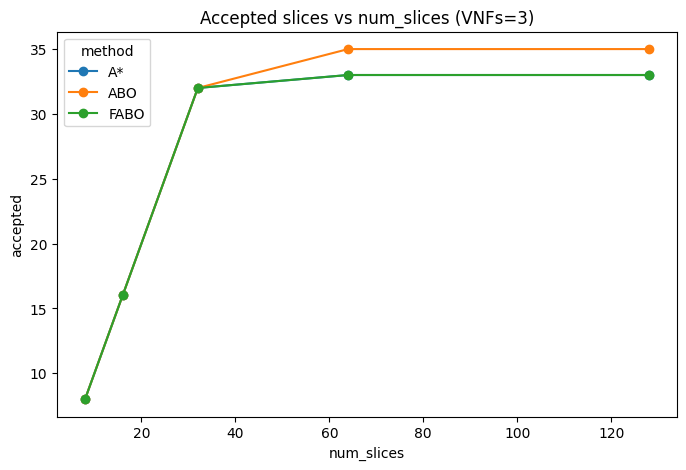

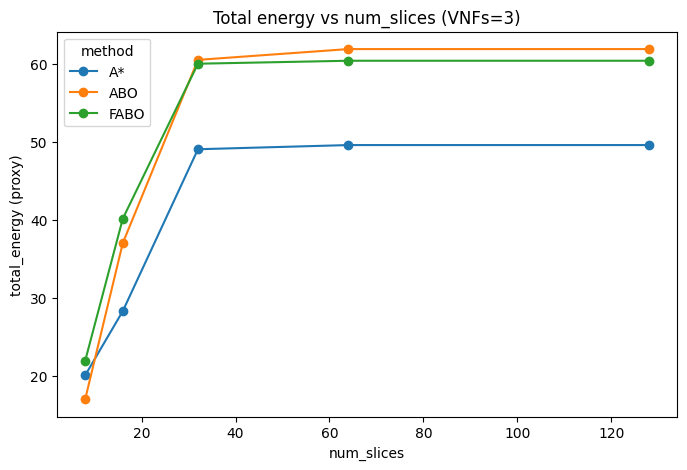

In [ ]:
import pandas as pd

# If df_results is already in memory from the loop, we reuse it.
# Otherwise, load from last CSV:
df_results = pd.read_csv("./results/2025-12-12_08-27-50/scalability_results.csv")

# Filter for this experiment: 3 VNFs, seed única (ajuste se usar outra)
seed_used = 1  # change if you used a different seed

df_exp = df_results[
    (df_results["num_vnfs_per_slice"] == 3)
    & (df_results["seed"] == seed_used)
].copy()

print("[INFO] Rows in this experiment:", len(df_exp))
display(df_exp.head())

# ==============================
# 1) Accepted slices vs num_slices (all methods)
# ==============================

print("\n=== Accepted slices vs num_slices (VNFs=3, seed={}) ===".format(seed_used))
pivot_acc = df_exp.pivot_table(
    index="num_slices",
    columns="method",
    values="accepted",
    aggfunc="max",  # only one row per combo anyway
).sort_index()

display(pivot_acc)

# ==============================
# 2) Total energy vs num_slices (all methods)
# ==============================

print("\n=== Total energy vs num_slices (VNFs=3, seed={}) ===".format(seed_used))
pivot_energy = df_exp.pivot_table(
    index="num_slices",
    columns="method",
    values="total_energy",
    aggfunc="max",
).sort_index()

display(pivot_energy)

# Optional: quick line plots (if you want)
try:
    ax = pivot_acc.plot(marker="o", figsize=(8, 5), title="Accepted slices vs num_slices (VNFs=3)")
    ax.set_xlabel("num_slices")
    ax.set_ylabel("accepted")
except Exception as e:
    print("[WARN] Could not plot acceptance:", e)

try:
    ax = pivot_energy.plot(marker="o", figsize=(8, 5), title="Total energy vs num_slices (VNFs=3)")
    ax.set_xlabel("num_slices")
    ax.set_ylabel("total_energy (proxy)")
except Exception as e:
    print("[WARN] Could not plot energy:", e)


[INFO] Rows in this experiment: 75


timestamp  num_slices  num_vnfs_per_slice  total_vnfs  seed  \
75  2025-12-12 08:44:31           8                   3          24     1   
76  2025-12-12 08:44:31           8                   3          24     1   
77  2025-12-12 08:44:31           8                   3          24     1   
78  2025-12-12 08:45:50          16                   3          48     1   
79  2025-12-12 08:45:50          16                   3          48     1   

   method  accepted  total_energy  total_bandwidth  total_latency  \
75     A*         8     20.107500            560.0           16.0   
76    ABO         8     17.057500            560.0           24.0   
77   FABO         8     21.987500            560.0           24.0   
78     A*        16     28.331875           1150.0           33.0   
79    ABO        16     37.049375           1180.0           54.0   

    runtime_sec  acceptance_rate  
75     0.371497              1.0  
76    26.857719              1.0  
77    23.296439              1.0  
78     0.686584              1.0  
79    38.754612              1.0


=== Acceptance rate (mean ± std) over seeds ===


num_slices method      mean  std
0            8     A*  1.000000  0.0
1            8    ABO  1.000000  0.0
2            8   FABO  1.000000  0.0
3           16     A*  1.000000  0.0
4           16    ABO  1.000000  0.0
5           16   FABO  1.000000  0.0
6           32     A*  1.000000  0.0
7           32    ABO  1.000000  0.0
8           32   FABO  1.000000  0.0
9           64     A*  0.515625  0.0
10          64    ABO  0.546875  0.0
11          64   FABO  0.515625  0.0
12         128     A*  0.257812  0.0
13         128    ABO  0.273438  0.0
14         128   FABO  0.257812  0.0


=== Mean acceptance rate per method (wide table) ===


method            A*       ABO      FABO
num_slices                              
8           1.000000  1.000000  1.000000
16          1.000000  1.000000  1.000000
32          1.000000  1.000000  1.000000
64          0.515625  0.546875  0.515625
128         0.257812  0.273438  0.257812

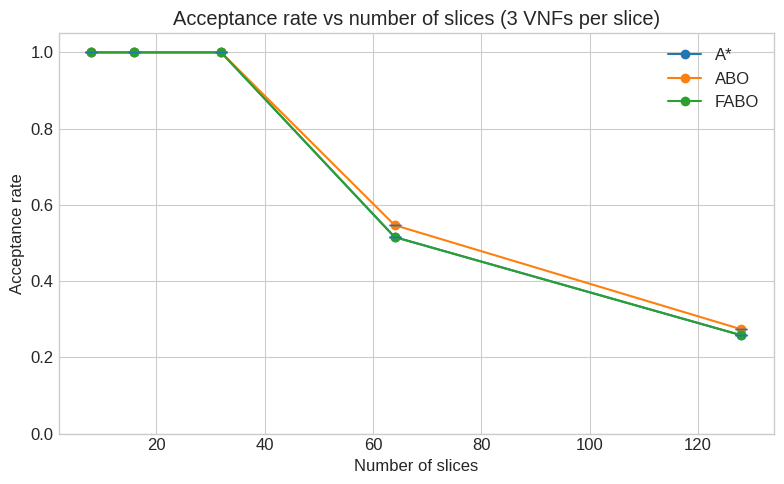

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ==============================
# Load results
# ==============================

# Ajuste o caminho se precisar (use ./results e não /results se estiver no projeto)
csv_path = "./results/2025-12-12_08-27-50/scalability_results.csv"
df_results = pd.read_csv(csv_path)

# Garante que a acceptance_rate existe
if "acceptance_rate" not in df_results.columns:
    df_results["acceptance_rate"] = (
        df_results["accepted"] / df_results["num_slices"]
    )

# ==============================
# Filtrar cenário de interesse
# ==============================

# Aqui: cadeias de 3 VNFs, todas as seeds
df_exp = df_results[df_results["num_vnfs_per_slice"] == 3].copy()

print("[INFO] Rows in this experiment:", len(df_exp))
display(df_exp.head())

# Métodos que queremos para o slide
target_methods = ["A*", "ABO", "FABO"]
df_exp = df_exp[df_exp["method"].isin(target_methods)].copy()

# ==============================
# Tabela: taxa de aceitação média e desvio por método
# ==============================

grouped_acc = (
    df_exp
    .groupby(["num_slices", "method"])["acceptance_rate"]
    .agg(["mean", "std"])
    .reset_index()
    .sort_values(["num_slices", "method"])
)

print("\n=== Acceptance rate (mean ± std) over seeds ===")
display(grouped_acc.head(30))

# Também em formato “wide” para inspecionar rápido
pivot_acc_mean = grouped_acc.pivot(
    index="num_slices", columns="method", values="mean"
).sort_index()
print("\n=== Mean acceptance rate per method (wide table) ===")
display(pivot_acc_mean)

# ==============================
# Gráfico para slide: taxa de aceitação vs número de slices
# ==============================

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.size"] = 12

fig, ax = plt.subplots()

for method in target_methods:
    sub = grouped_acc[grouped_acc["method"] == method]

    ax.plot(
        sub["num_slices"],
        sub["mean"],
        marker="o",
        label=method,
    )
    # Se quiser barras de erro, descomente:
    ax.errorbar(
         sub["num_slices"],
         sub["mean"],
         yerr=sub["std"],
         fmt="none",
         capsize=4,
     )

ax.set_xlabel("Number of slices")
ax.set_ylabel("Acceptance rate")
ax.set_title("Acceptance rate vs number of slices (3 VNFs per slice)")
ax.set_ylim(0, 1.05)
ax.legend()
plt.tight_layout()
plt.show()


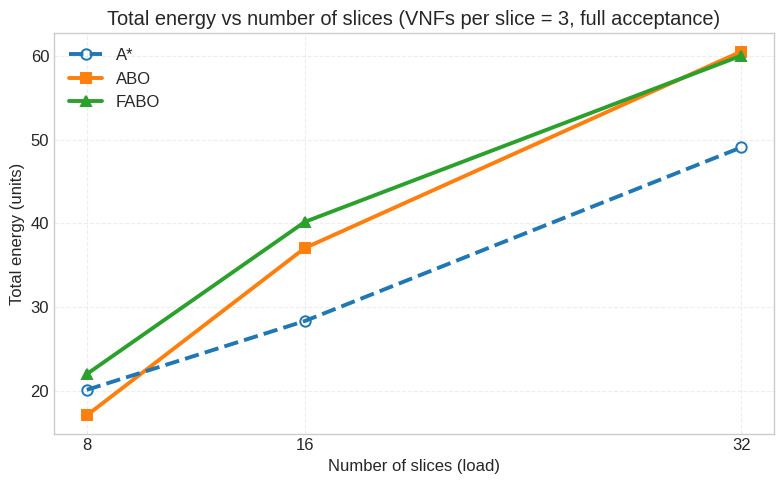

In [21]:
# Plot total energy vs number of slices (VNFs = 3) under full acceptance
# Conference-ready formatting, no error bars

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Helper: detect energy column
# ----------------------------
energy_col_candidates = [
    "total_energy", "energy_total", "total_energy_units", "energy",
    "E_total", "E", "total_power", "power_total"
]
energy_col = next((c for c in energy_col_candidates if c in df_results.columns), None)

if energy_col is None:
    raise KeyError(
        "No energy column found in df_results. "
        "Expected one of: " + ", ".join(energy_col_candidates) +
        f". Available columns: {list(df_results.columns)}"
    )

# ----------------------------
# Filter scenario: VNFs = 3 and target methods
# ----------------------------
df_exp = df_results[df_results["num_vnfs_per_slice"] == 3].copy()
df_exp = df_exp[df_exp["method"].isin(target_methods)].copy()

# Ensure acceptance_rate exists
if "acceptance_rate" not in df_exp.columns:
    df_exp["acceptance_rate"] = df_exp["accepted"] / df_exp["num_slices"]

# Full acceptance filter (tolerant to float noise)
df_full = df_exp[np.isclose(df_exp["acceptance_rate"], 1.0, atol=1e-9)].copy()

if df_full.empty:
    raise ValueError(
        "No rows found with full acceptance (acceptance_rate == 1.0) for VNFs=3. "
        "Check if you computed acceptance_rate correctly or if full-acceptance points exist."
    )

# ----------------------------
# Aggregate mean energy over seeds
# ----------------------------
grouped_energy_full = (
    df_full
    .groupby(["num_slices", "method"], as_index=False)[energy_col]
    .mean()
    .sort_values(["num_slices", "method"])
)

# ----------------------------
# Plot
# ----------------------------
fig, ax = plt.subplots()

marker_map = {"A*": "o", "ABO": "s", "FABO": "^"}
linestyle_map = {"A*": "--", "ABO": "-", "FABO": "-"}
zorder_map = {"A*": 5, "ABO": 3, "FABO": 3}

for method in target_methods:
    sub = grouped_energy_full[grouped_energy_full["method"] == method]

    ax.plot(
        sub["num_slices"],
        sub[energy_col],
        marker=marker_map[method],
        linestyle=linestyle_map[method],
        linewidth=2.8,
        markersize=7.5,
        markerfacecolor="none" if method == "A*" else None,
        markeredgewidth=1.4,
        label=method,
        zorder=zorder_map[method]
    )

ax.set_xlabel("Number of slices (load)")
ax.set_ylabel("Total energy (units)")
ax.set_title("Total energy vs number of slices (VNFs per slice = 3, full acceptance)")
ax.set_xticks(sorted(grouped_energy_full["num_slices"].unique()))
ax.grid(True, linestyle="--", linewidth=0.8, alpha=0.35)
ax.legend(frameon=False, loc="upper left")

plt.tight_layout()
plt.show()


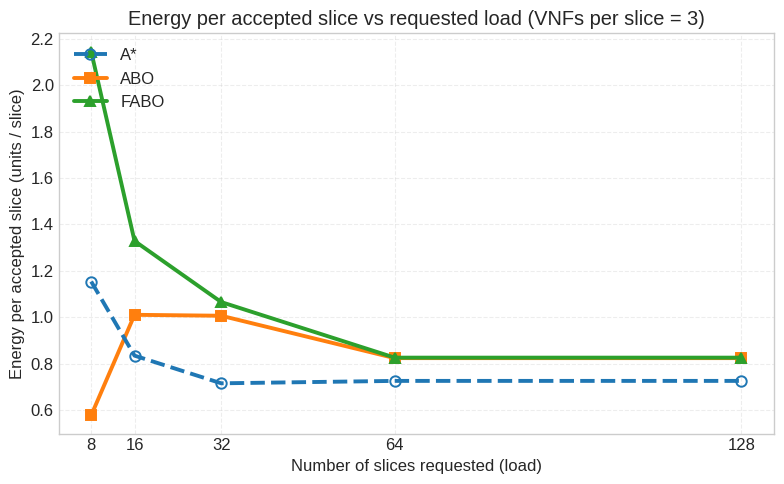

In [22]:
# Plot energy per accepted slice vs number of requested slices (VNFs = 3)
# Conference-ready formatting, no error bars

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Filter scenario: VNFs = 3 and target methods
# ----------------------------
df_exp = df_results[df_results["num_vnfs_per_slice"] == 2].copy()
df_exp = df_exp[df_exp["method"].isin(target_methods)].copy()

# Ensure acceptance_rate exists
if "acceptance_rate" not in df_exp.columns:
    df_exp["acceptance_rate"] = df_exp["accepted"] / df_exp["num_slices"]

# ----------------------------
# Compute accepted slices count
# ----------------------------
# If "accepted" is already a count of accepted slices per run, use it.
# Otherwise, derive it from acceptance_rate * num_slices.
accepted_is_count = np.issubdtype(df_exp["accepted"].dtype, np.number) and (df_exp["accepted"].max() > 1)

if accepted_is_count:
    df_exp["accepted_slices"] = df_exp["accepted"].astype(float)
else:
    df_exp["accepted_slices"] = (df_exp["acceptance_rate"] * df_exp["num_slices"]).astype(float)

# Avoid division by zero
df_exp = df_exp[df_exp["accepted_slices"] > 0].copy()

# ----------------------------
# Compute energy per accepted slice
# ----------------------------
energy_col_candidates = [
    "total_energy", "energy_total", "total_energy_units", "energy",
    "E_total", "E", "total_power", "power_total"
]
energy_col = next((c for c in energy_col_candidates if c in df_results.columns), None)

if energy_col is None:
    raise KeyError(
        "No energy column found in df_results. "
        "Expected one of: " + ", ".join(energy_col_candidates) +
        f". Available columns: {list(df_results.columns)}"
    )

df_exp["energy_per_accepted_slice"] = df_exp[energy_col] / df_exp["accepted_slices"]

# ----------------------------
# Aggregate mean over seeds
# ----------------------------
grouped_eps = (
    df_exp
    .groupby(["num_slices", "method"], as_index=False)["energy_per_accepted_slice"]
    .mean()
    .sort_values(["num_slices", "method"])
)

# ----------------------------
# Plot
# ----------------------------
fig, ax = plt.subplots()

marker_map = {"A*": "o", "ABO": "s", "FABO": "^"}
linestyle_map = {"A*": "--", "ABO": "-", "FABO": "-"}
zorder_map = {"A*": 5, "ABO": 3, "FABO": 3}

for method in target_methods:
    sub = grouped_eps[grouped_eps["method"] == method]

    ax.plot(
        sub["num_slices"],
        sub["energy_per_accepted_slice"],
        marker=marker_map[method],
        linestyle=linestyle_map[method],
        linewidth=2.8,
        markersize=7.5,
        markerfacecolor="none" if method == "A*" else None,
        markeredgewidth=1.4,
        label=method,
        zorder=zorder_map[method]
    )

ax.set_xlabel("Number of slices requested (load)")
ax.set_ylabel("Energy per accepted slice (units / slice)")
ax.set_title("Energy per accepted slice vs requested load (VNFs per slice = 3)")
ax.set_xticks(sorted(grouped_eps["num_slices"].unique()))
ax.grid(True, linestyle="--", linewidth=0.8, alpha=0.35)
ax.legend(frameon=False, loc="upper left")

plt.tight_layout()
plt.show()


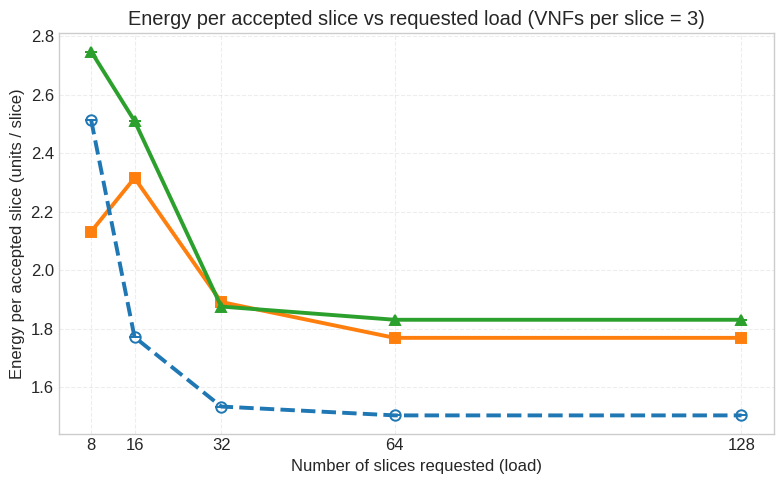

In [23]:
# Plot energy per accepted slice vs requested load (VNFs = 3)
# With error bars and no legend (conference-ready)

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Filter scenario
# ----------------------------
df_exp = df_results[df_results["num_vnfs_per_slice"] == 3].copy()
df_exp = df_exp[df_exp["method"].isin(target_methods)].copy()

# Ensure acceptance_rate exists
if "acceptance_rate" not in df_exp.columns:
    df_exp["acceptance_rate"] = df_exp["accepted"] / df_exp["num_slices"]

# ----------------------------
# Compute accepted slices
# ----------------------------
accepted_is_count = (
    np.issubdtype(df_exp["accepted"].dtype, np.number)
    and df_exp["accepted"].max() > 1
)

if accepted_is_count:
    df_exp["accepted_slices"] = df_exp["accepted"].astype(float)
else:
    df_exp["accepted_slices"] = df_exp["acceptance_rate"] * df_exp["num_slices"]

df_exp = df_exp[df_exp["accepted_slices"] > 0].copy()

# ----------------------------
# Detect energy column
# ----------------------------
energy_col_candidates = [
    "total_energy", "energy_total", "total_energy_units", "energy",
    "E_total", "E", "total_power", "power_total"
]
energy_col = next((c for c in energy_col_candidates if c in df_exp.columns), None)

if energy_col is None:
    raise KeyError(
        f"No energy column found. Available columns: {list(df_exp.columns)}"
    )

# ----------------------------
# Compute energy per accepted slice
# ----------------------------
df_exp["energy_per_accepted_slice"] = (
    df_exp[energy_col] / df_exp["accepted_slices"]
)

# ----------------------------
# Aggregate mean ± std over seeds
# ----------------------------
grouped_eps = (
    df_exp
    .groupby(["num_slices", "method"])["energy_per_accepted_slice"]
    .agg(["mean", "std"])
    .reset_index()
    .sort_values(["num_slices", "method"])
)

# ----------------------------
# Plot
# ----------------------------
fig, ax = plt.subplots()

marker_map = {"A*": "o", "ABO": "s", "FABO": "^"}
linestyle_map = {"A*": "--", "ABO": "-", "FABO": "-"}
zorder_map = {"A*": 5, "ABO": 3, "FABO": 3}

for method in target_methods:
    sub = grouped_eps[grouped_eps["method"] == method]

    ax.errorbar(
        sub["num_slices"],
        sub["mean"],
        yerr=sub["std"],
        marker=marker_map[method],
        linestyle=linestyle_map[method],
        linewidth=2.8,
        markersize=7.5,
        markerfacecolor="none" if method == "A*" else None,
        markeredgewidth=1.4,
        capsize=4,
        zorder=zorder_map[method]
    )

# ----------------------------
# Axes formatting
# ----------------------------
ax.set_xlabel("Number of slices requested (load)")
ax.set_ylabel("Energy per accepted slice (units / slice)")
ax.set_title("Energy per accepted slice vs requested load (VNFs per slice = 3)")

ax.set_xticks(sorted(grouped_eps["num_slices"].unique()))
ax.grid(True, linestyle="--", linewidth=0.8, alpha=0.35)

# No legend on purpose (clean slide)
# ax.legend(...)

plt.tight_layout()
plt.show()


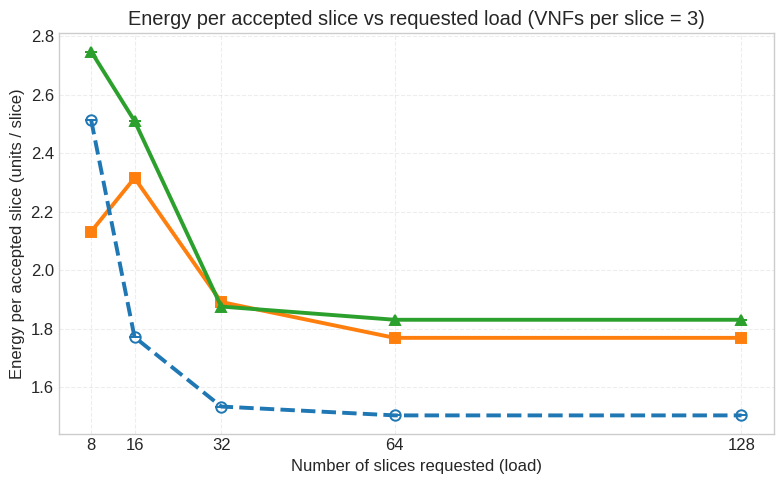

In [17]:
# Plot energy per accepted slice vs requested load (VNFs = 3)
# With error bars and no legend (conference-ready)

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Filter scenario
# ----------------------------
df_exp = df_results[df_results["num_vnfs_per_slice"] == 3].copy()
df_exp = df_exp[df_exp["method"].isin(target_methods)].copy()

# Ensure acceptance_rate exists
if "acceptance_rate" not in df_exp.columns:
    df_exp["acceptance_rate"] = df_exp["accepted"] / df_exp["num_slices"]

# ----------------------------
# Compute accepted slices
# ----------------------------
accepted_is_count = (
    np.issubdtype(df_exp["accepted"].dtype, np.number)
    and df_exp["accepted"].max() > 1
)

if accepted_is_count:
    df_exp["accepted_slices"] = df_exp["accepted"].astype(float)
else:
    df_exp["accepted_slices"] = df_exp["acceptance_rate"] * df_exp["num_slices"]

df_exp = df_exp[df_exp["accepted_slices"] > 0].copy()

# ----------------------------
# Detect energy column
# ----------------------------
energy_col_candidates = [
    "total_energy", "energy_total", "total_energy_units", "energy",
    "E_total", "E", "total_power", "power_total"
]
energy_col = next((c for c in energy_col_candidates if c in df_exp.columns), None)

if energy_col is None:
    raise KeyError(
        f"No energy column found. Available columns: {list(df_exp.columns)}"
    )

# ----------------------------
# Compute energy per accepted slice
# ----------------------------
df_exp["energy_per_accepted_slice"] = (
    df_exp[energy_col] / df_exp["accepted_slices"]
)

# ----------------------------
# Aggregate mean ± std over seeds
# ----------------------------
grouped_eps = (
    df_exp
    .groupby(["num_slices", "method"])["energy_per_accepted_slice"]
    .agg(["mean", "std"])
    .reset_index()
    .sort_values(["num_slices", "method"])
)

# ----------------------------
# Plot
# ----------------------------
fig, ax = plt.subplots()

marker_map = {"A*": "o", "ABO": "s", "FABO": "^"}
linestyle_map = {"A*": "--", "ABO": "-", "FABO": "-"}
zorder_map = {"A*": 5, "ABO": 3, "FABO": 3}

for method in target_methods:
    sub = grouped_eps[grouped_eps["method"] == method]

    ax.errorbar(
        sub["num_slices"],
        sub["mean"],
        yerr=sub["std"],
        marker=marker_map[method],
        linestyle=linestyle_map[method],
        linewidth=2.8,
        markersize=7.5,
        markerfacecolor="none" if method == "A*" else None,
        markeredgewidth=1.4,
        capsize=4,
        zorder=zorder_map[method]
    )

# ----------------------------
# Axes formatting
# ----------------------------
ax.set_xlabel("Number of slices requested (load)")
ax.set_ylabel("Energy per accepted slice (units / slice)")
ax.set_title("Energy per accepted slice vs requested load (VNFs per slice = 3)")

ax.set_xticks(sorted(grouped_eps["num_slices"].unique()))
ax.grid(True, linestyle="--", linewidth=0.8, alpha=0.35)

# No legend on purpose (clean slide)
# ax.legend(...)

plt.tight_layout()
plt.show()


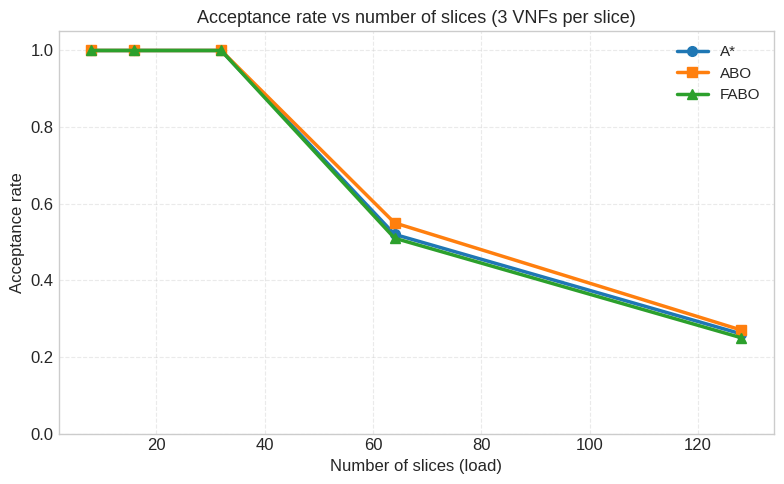

In [ ]:
# Plot acceptance rate vs number of slices (VNFs = 3)
# Clean version: no std, high-contrast lines, conference-ready

import matplotlib.pyplot as plt

# ----------------------------
# Data (replace if needed)
# ----------------------------
num_slices = [8, 16, 32, 64, 128]

accept_astar = [1.0, 1.0, 1.0, 0.52, 0.26]
accept_abo   = [1.0, 1.0, 1.0, 0.55, 0.27]
accept_fabo  = [1.0, 1.0, 1.0, 0.51, 0.25]

# ----------------------------
# Plot
# ----------------------------
plt.figure(figsize=(8, 5))

plt.plot(
    num_slices, accept_astar,
    marker="o", linewidth=2.5, markersize=7,
    label="A*"
)

plt.plot(
    num_slices, accept_abo,
    marker="s", linewidth=2.5, markersize=7,
    label="ABO"
)

plt.plot(
    num_slices, accept_fabo,
    marker="^", linewidth=2.5, markersize=7,
    label="FABO"
)

# ----------------------------
# Axes and labels
# ----------------------------
plt.xlabel("Number of slices (load)", fontsize=12)
plt.ylabel("Acceptance rate", fontsize=12)
plt.title("Acceptance rate vs number of slices (3 VNFs per slice)", fontsize=13)

plt.ylim(0.0, 1.05)
plt.grid(True, linestyle="--", alpha=0.4)

# ----------------------------
# Legend
# ----------------------------
plt.legend(frameon=False, fontsize=11)

plt.tight_layout()
plt.show()


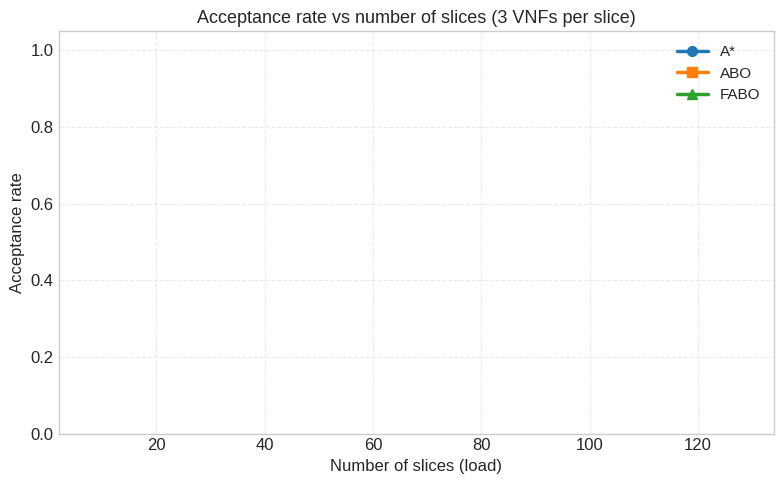

In [ ]:
# Plot acceptance rate vs number of slices (VNFs = 3)
# Computed from raw results (mean over seeds, no std)

import matplotlib.pyplot as plt
import pandas as pd

# ----------------------------
# Filter scenario
# ----------------------------
df_plot = df_results.copy()
df_plot = df_plot[df_plot["num_vnfs_per_slice"] == 3]

# ----------------------------
# Compute acceptance rate
# ----------------------------
df_acc = (
    df_plot
    .groupby(["num_slices", "method"])["accepted"]
    .mean()
    .reset_index()
)

# ----------------------------
# Plot
# ----------------------------
plt.figure(figsize=(8, 5))

for method, marker in zip(["A*", "ABO", "FABO"], ["o", "s", "^"]):
    df_m = df_acc[df_acc["method"] == method]
    plt.plot(
        df_m["num_slices"],
        df_m["accepted"],
        marker=marker,
        linewidth=2.5,
        markersize=7,
        label=method
    )

# ----------------------------
# Styling
# ----------------------------
plt.xlabel("Number of slices (load)", fontsize=12)
plt.ylabel("Acceptance rate", fontsize=12)
plt.title("Acceptance rate vs number of slices (3 VNFs per slice)", fontsize=13)

plt.ylim(0.0, 1.05)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(frameon=False, fontsize=11)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Carrega o CSV de escalabilidade
df_results = pd.read_csv("./results/2025-12-09_18-42-13/scalability_results.csv")

methods = ["A*", "ABO", "FABO"]

# Garante a coluna de taxa de aceitação
df_results["acceptance_rate"] = df_results["accepted"] / df_results["num_slices"]

# Só cenários desses três métodos
sub = df_results[df_results["method"].isin(methods)].copy()

# Aceitação por cenário (num_slices, num_vnfs_per_slice, seed, method)
acc = (
    sub.groupby(["num_slices", "num_vnfs_per_slice", "seed", "method"])["acceptance_rate"]
       .max()
       .reset_index()
)

# Pivot para ver, por cenário, a taxa de aceitação de cada método
acc_pivot = acc.pivot(
    index=["num_slices", "num_vnfs_per_slice", "seed"],
    columns="method",
    values="acceptance_rate",
)

# Cenários onde TODOS os três métodos têm aceitação 100%
mask_full = (acc_pivot[methods] >= 0.9999).all(axis=1)
full_scenarios = acc_pivot[mask_full].reset_index()

print("[INFO] Número de cenários com 100% de aceitação para A*, ABO e FABO:", len(full_scenarios))

# Agora calcula energia por slice aceito
sub["energy_per_accepted_slice"] = sub["total_energy"] / sub["accepted"]

# Mantém só os cenários totalmente aceitos
full_energy = sub.merge(
    full_scenarios[["num_slices", "num_vnfs_per_slice", "seed"]],
    on=["num_slices", "num_vnfs_per_slice", "seed"],
    how="inner",
)

# Tabela final: energia por slice aceito, por cenário e método
table_energy = (
    full_energy
    .pivot_table(
        index=["num_vnfs_per_slice", "num_slices", "seed"],
        columns="method",
        values="energy_per_accepted_slice",
        aggfunc="mean",
    )
    .sort_index()
)

display(table_energy)


[INFO] Número de cenários com 100% de aceitação para A*, ABO e FABO: 40


method                                    A*       ABO      FABO
num_vnfs_per_slice num_slices seed                              
2                  8          1     1.153750  0.576875  2.144609
                              2     1.153750  0.576875  2.144609
                              3     1.153750  0.576875  2.144609
                              4     1.153750  0.576875  2.144609
                              5     1.153750  0.576875  2.144609
                   16         1     0.834336  1.010234  1.328359
                              2     0.834336  1.010234  1.328359
                              3     0.834336  1.010234  1.328359
                              4     0.834336  1.010234  1.328359
                              5     0.834336  1.010234  1.328359
                   32         1     0.715098  1.006172  1.065098
                              2     0.715098  1.006172  1.065098
                              3     0.715098  1.006172  1.065098
                              4     0.715098  1.006172  1.065098
                              5     0.715098  1.006172  1.065098
3                  8          1     2.513438  2.132188  2.748438
                              2     2.513438  2.132188  2.748438
                              3     2.513438  2.132188  2.748438
                              4     2.513438  2.132188  2.748438
                              5     2.513438  2.132188  2.748438
                   16         1     1.770742  2.315586  2.510742
                              2     1.770742  2.315586  2.510742
                              3     1.770742  2.315586  2.510742
                              4     1.770742  2.315586  2.510742
                              5     1.770742  2.315586  2.510742
                   32         1     1.533164  1.890918  1.875508
                              2     1.533164  1.890918  1.875508
                              3     1.533164  1.890918  1.875508
                              4     1.533164  1.890918  1.875508
                              5     1.533164  1.890918  1.875508
4                  8          1     4.220000  4.003125  4.437891
                              2     4.220000  4.003125  4.437891
                              3     4.220000  4.003125  4.437891
                              4     4.220000  4.003125  4.437891
                              5     4.220000  4.003125  4.437891
5                  8          1     5.087656  5.840781  6.252656
                              2     5.087656  5.840781  6.252656
                              3     5.087656  5.840781  6.252656
                              4     5.087656  5.840781  6.252656
                              5     5.087656  5.840781  6.252656

[INFO] Valid scenarios: 40


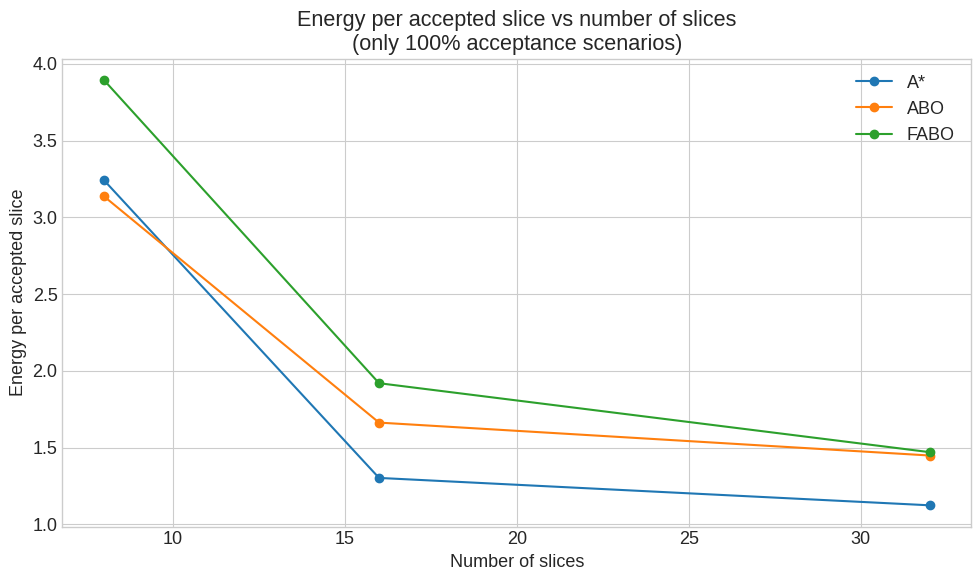

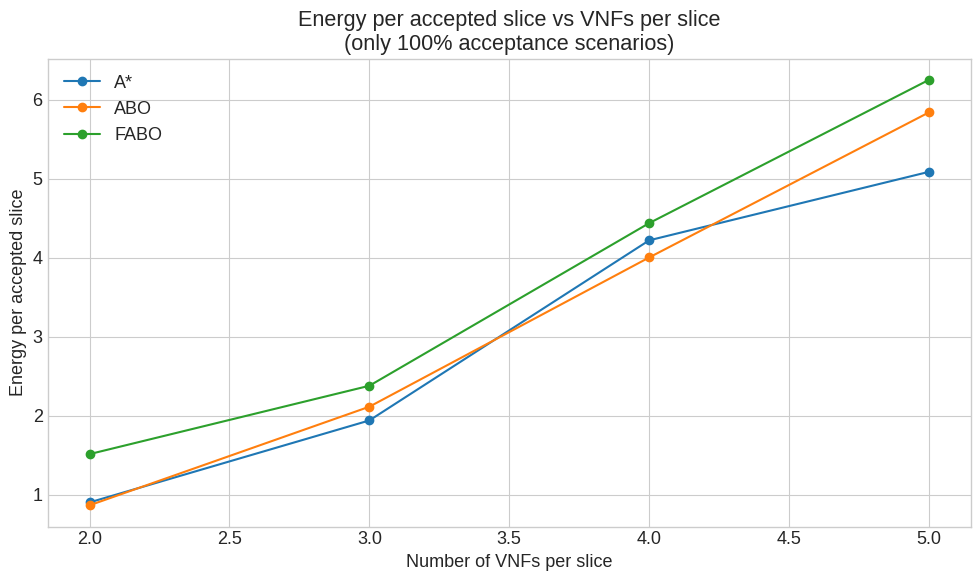

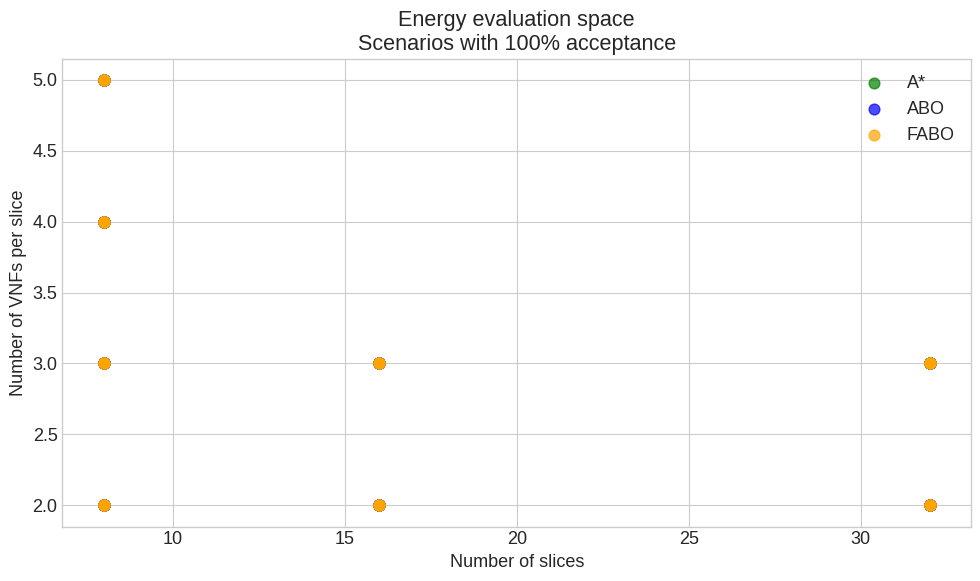

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 13

# ================================
# Load data
# ================================
df = pd.read_csv("./results/2025-12-12_08-27-50/scalability_results.csv")
methods = ["A*", "ABO", "FABO"]

df["acceptance_rate"] = df["accepted"] / df["num_slices"]

# ================================
# Find scenarios where ALL 3 methods accept 100%
# ================================
acc = (
    df[df["method"].isin(methods)]
    .groupby(["num_slices", "num_vnfs_per_slice", "seed", "method"])["acceptance_rate"]
    .max()
    .reset_index()
)

pivot_acc = acc.pivot(
    index=["num_slices", "num_vnfs_per_slice", "seed"],
    columns="method",
    values="acceptance_rate"
)

mask = (pivot_acc[["A*", "ABO", "FABO"]] >= 0.9999).all(axis=1)
full_ok = pivot_acc[mask].reset_index()

print("[INFO] Valid scenarios:", len(full_ok))

df["energy_per_slice"] = df["total_energy"] / df["accepted"]

df_ok = df.merge(full_ok, on=["num_slices", "num_vnfs_per_slice", "seed"], how="inner")
df_ok = df_ok[df_ok["method"].isin(methods)]

# ============================================
# GRAPH 1 — Energy per accepted slice vs num_slices
# ============================================
fig, ax = plt.subplots()

for m in methods:
    sub = df_ok[df_ok["method"] == m]
    grouped = sub.groupby("num_slices")["energy_per_slice"].mean()
    ax.plot(grouped.index, grouped.values, marker="o", label=m)

ax.set_title("Energy per accepted slice vs number of slices\n(only 100% acceptance scenarios)")
ax.set_xlabel("Number of slices")
ax.set_ylabel("Energy per accepted slice")
ax.legend()
plt.tight_layout()
plt.show()

# ============================================
# GRAPH 2 — Energy per accepted slice vs num_vnfs_per_slice
# ============================================
fig, ax = plt.subplots()

for m in methods:
    sub = df_ok[df_ok["method"] == m]
    grouped = sub.groupby("num_vnfs_per_slice")["energy_per_slice"].mean()
    ax.plot(grouped.index, grouped.values, marker="o", label=m)

ax.set_title("Energy per accepted slice vs VNFs per slice\n(only 100% acceptance scenarios)")
ax.set_xlabel("Number of VNFs per slice")
ax.set_ylabel("Energy per accepted slice")
ax.legend()
plt.tight_layout()
plt.show()

# ============================================
# GRAPH 3 — Heatmap-like scatter plot (2D energy frontier)
# ============================================
fig, ax = plt.subplots()

colors = {"A*": "green", "ABO": "blue", "FABO": "orange"}

for m in methods:
    sub = df_ok[df_ok["method"] == m]
    ax.scatter(
        sub["num_slices"],
        sub["num_vnfs_per_slice"],
        s=60,
        c=colors[m],
        label=m,
        alpha=0.7
    )

ax.set_title("Energy evaluation space\nScenarios with 100% acceptance")
ax.set_xlabel("Number of slices")
ax.set_ylabel("Number of VNFs per slice")
ax.legend()
plt.tight_layout()
plt.show()


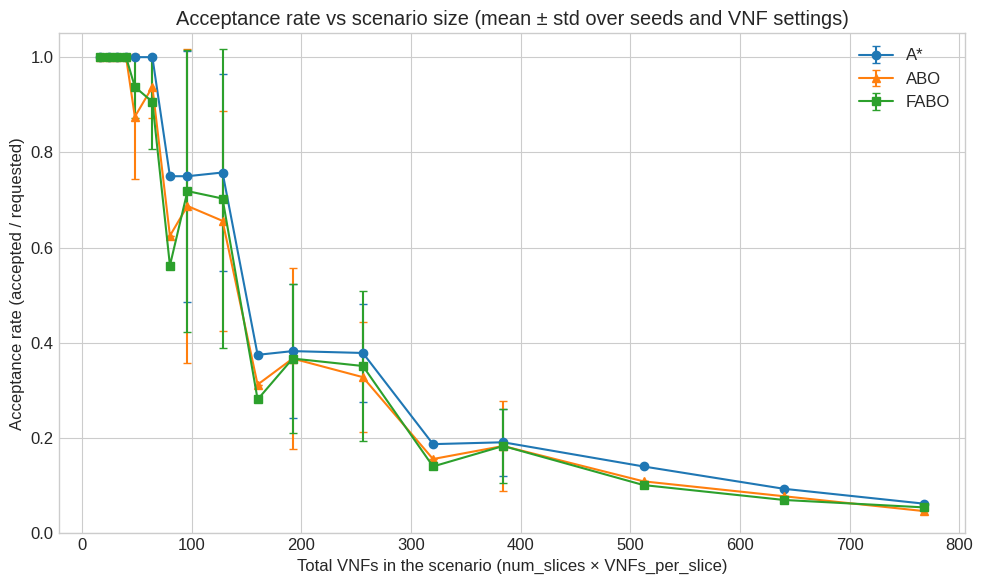

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "./results/2025-12-12_08-27-50/scalability_results.csv"
df = pd.read_csv(csv_path)

METHODS = ["A*", "ABO", "FABO"]
df = df[df["method"].isin(METHODS)].copy()

df["acceptance_rate"] = df["accepted"] / df["num_slices"]

# Aggregate across ALL VNFs/loads/seeds using a common X = total_vnfs
agg = (
    df.groupby(["method", "total_vnfs"])["acceptance_rate"]
      .agg(mean="mean", std="std", n="count")
      .reset_index()
      .sort_values("total_vnfs")
)

markers = {"A*": "o", "ABO": "^", "FABO": "s"}

plt.figure(figsize=(10, 6))
for m in METHODS:
    sub = agg[agg["method"] == m]
    plt.errorbar(
        sub["total_vnfs"], sub["mean"], yerr=sub["std"],
        marker=markers[m], capsize=3, label=m
    )

plt.xlabel("Total VNFs in the scenario (num_slices × VNFs_per_slice)")
plt.ylabel("Acceptance rate (accepted / requested)")
plt.title("Acceptance rate vs scenario size (mean ± std over seeds and VNF settings)")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


                    max_seeds_in_any_point
num_vnfs_per_slice                        
2                                        5
3                                        5
4                                        5
5                                        5
6                                        5


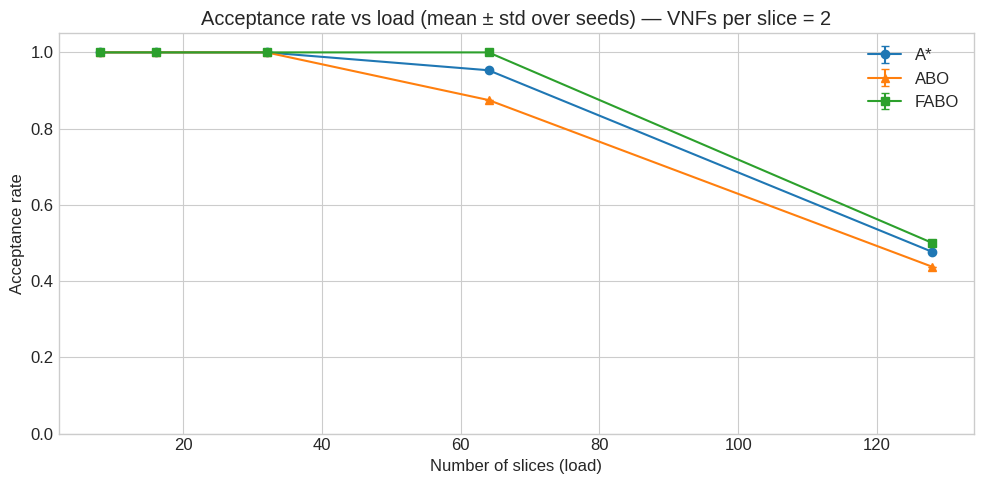

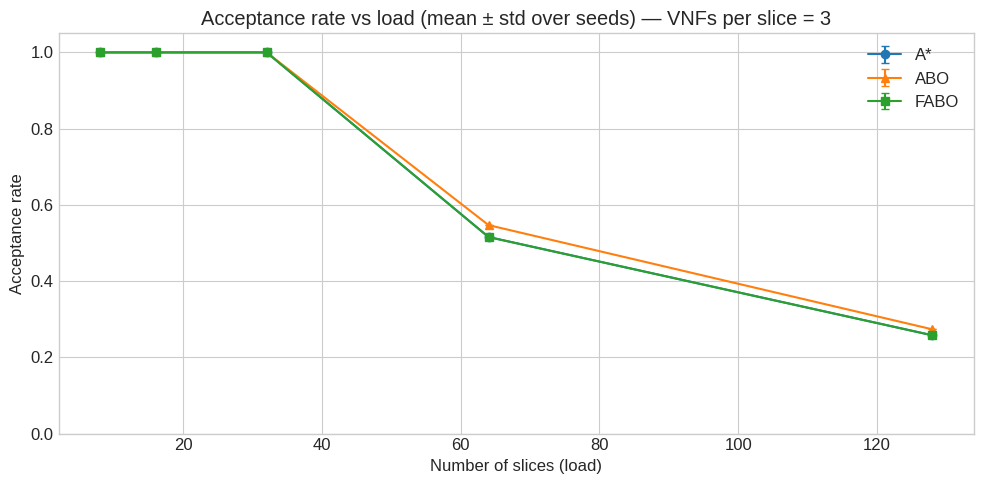

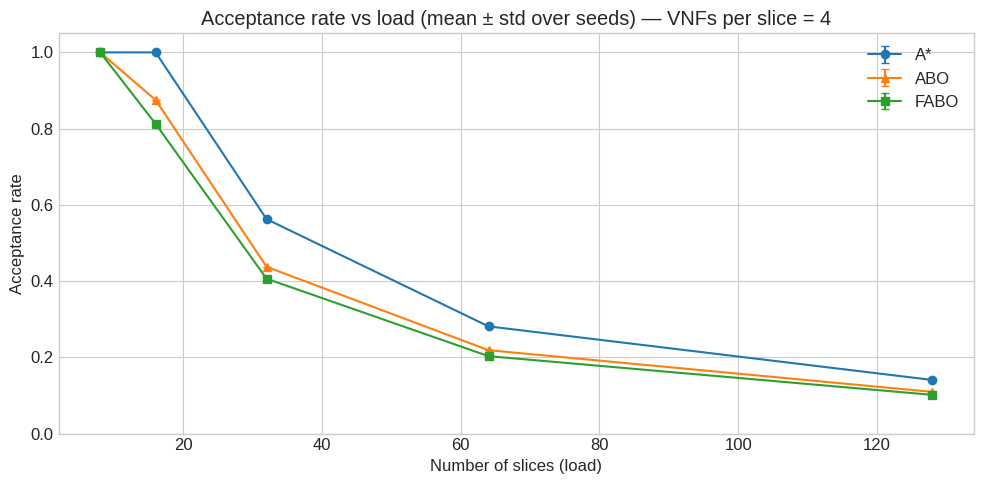

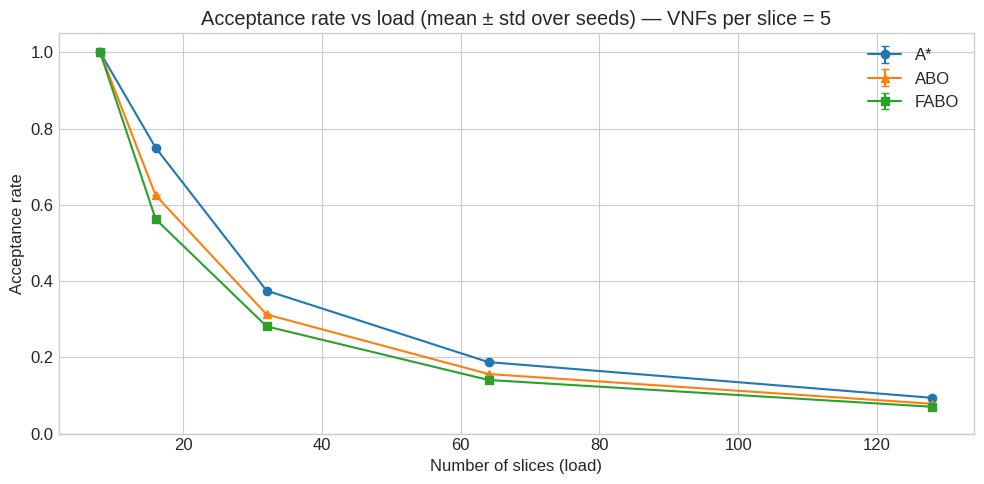

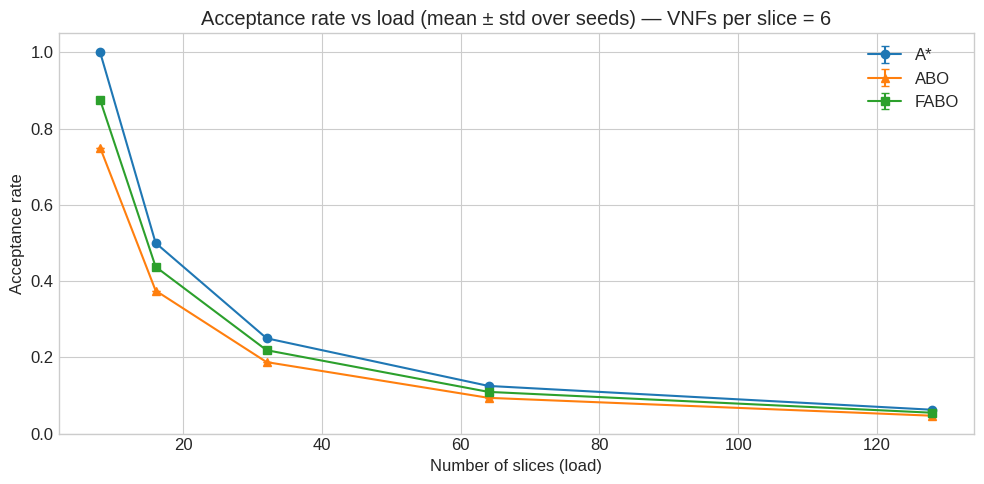

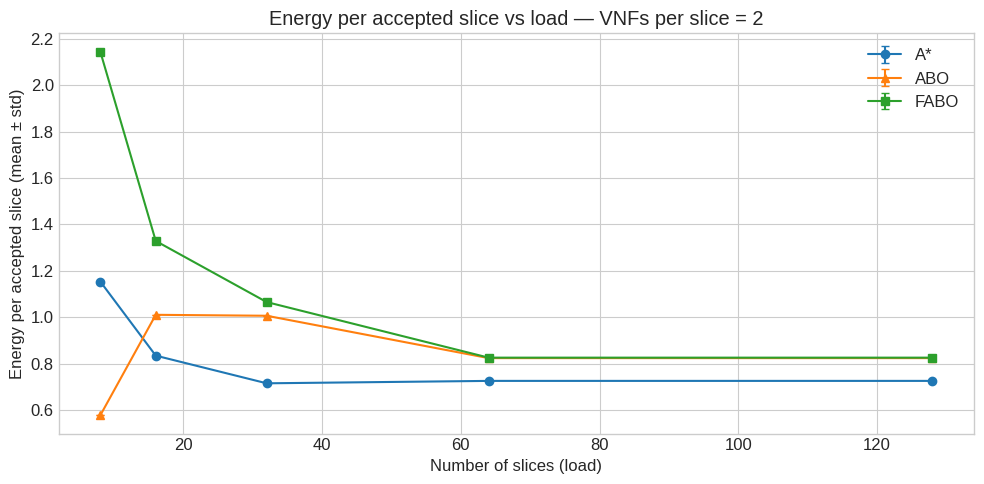

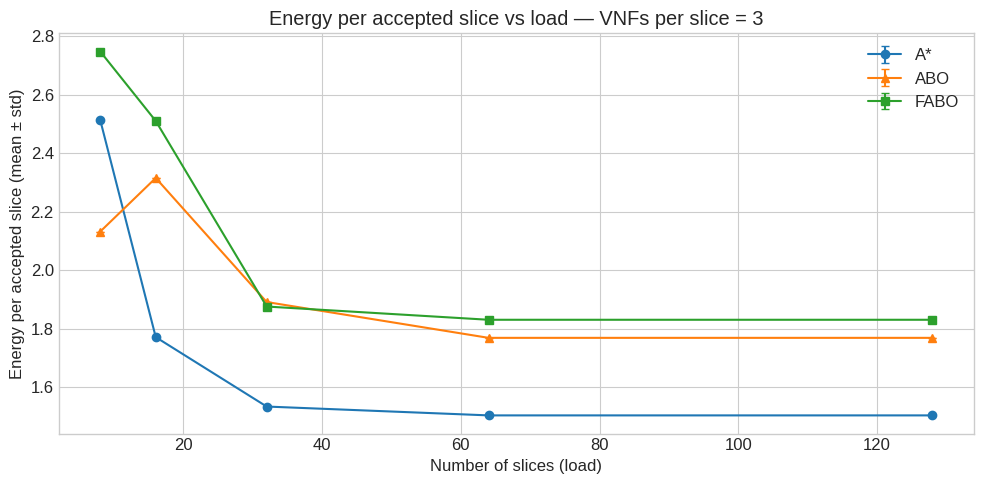

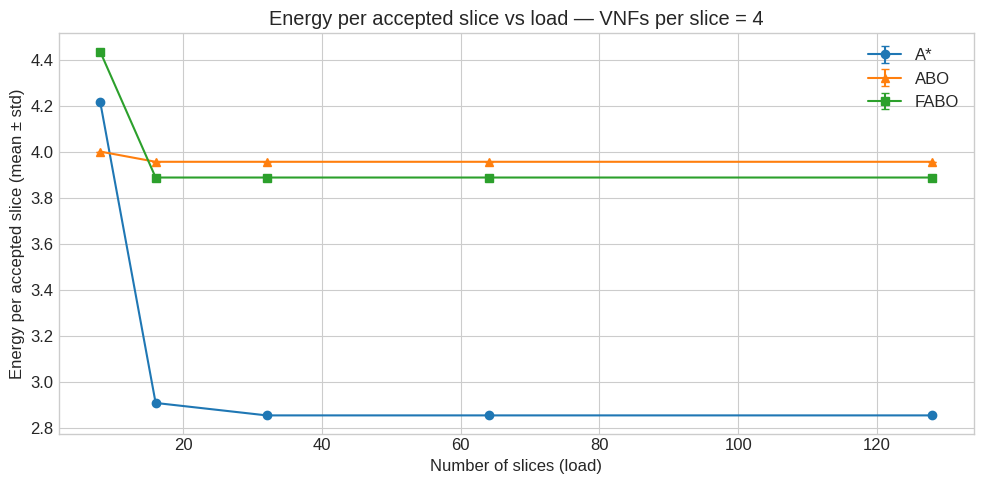

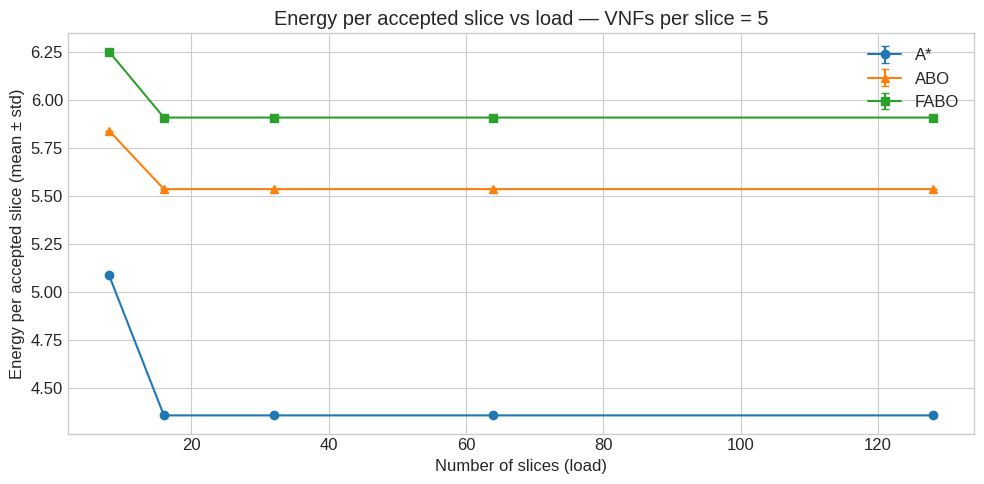

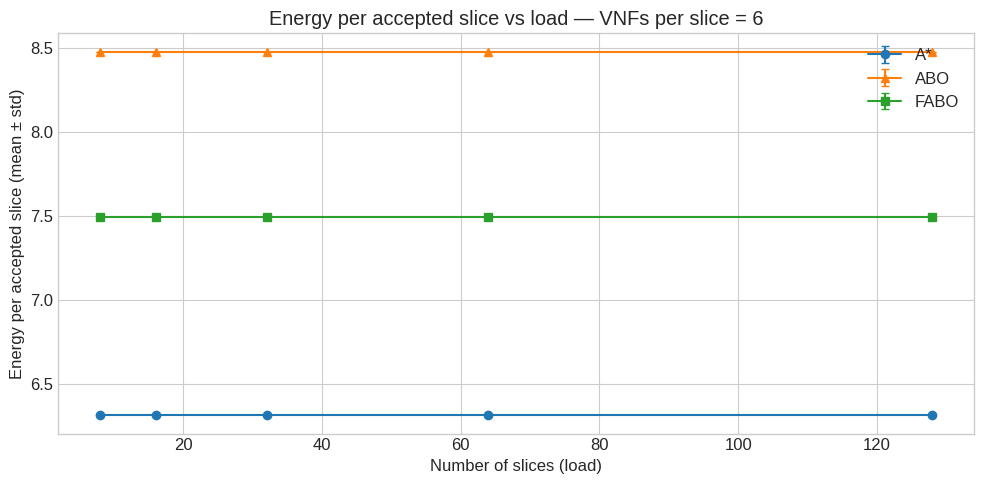

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Load results
# =========================
CSV_PATH = "./results/2025-12-12_08-27-50/scalability_results.csv"  # <-- change here
df = pd.read_csv(CSV_PATH)

# Keep only the 3 methods
METHODS = ["A*", "ABO", "FABO"]
df = df[df["method"].isin(METHODS)].copy()

# Basic sanity
needed_cols = {"num_slices","num_vnfs_per_slice","seed","method","accepted","total_energy"}
missing = needed_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

# =========================
# Metrics
# =========================
df["acceptance_rate"] = df["accepted"] / df["num_slices"]
df["energy_per_accepted_slice"] = df["total_energy"] / df["accepted"].replace(0, np.nan)

# =========================
# Aggregate across seeds
# =========================
agg = (
    df.groupby(["num_vnfs_per_slice","num_slices","method"], as_index=False)
      .agg(
          seeds_n=("seed","nunique"),
          acc_mean=("acceptance_rate","mean"),
          acc_std=("acceptance_rate","std"),
          E_total_mean=("total_energy","mean"),
          E_total_std=("total_energy","std"),
          E_per_acc_mean=("energy_per_accepted_slice","mean"),
          E_per_acc_std=("energy_per_accepted_slice","std"),
      )
)

# Helpful note: std==0 often happens when seeds_n==1 OR results identical across seeds
print(
    agg.groupby("num_vnfs_per_slice")[["seeds_n"]].max()
       .rename(columns={"seeds_n":"max_seeds_in_any_point"})
)

# =========================
# Plot settings
# =========================
markers = {"A*":"o", "ABO":"^", "FABO":"s"}
methods_order = ["A*", "ABO", "FABO"]

vnf_values = sorted(agg["num_vnfs_per_slice"].unique())

# =========================
# 1) Acceptance rate vs load (per VNF)
# =========================
for vnf_len in vnf_values:
    sub = agg[agg["num_vnfs_per_slice"] == vnf_len].copy()
    if sub.empty:
        continue

    fig, ax = plt.subplots(figsize=(10, 5))

    for m in methods_order:
        mm = sub[sub["method"] == m].sort_values("num_slices")
        if mm.empty:
            continue

        x = mm["num_slices"]
        y = mm["acc_mean"]
        yerr = mm["acc_std"].fillna(0.0)

        ax.errorbar(
            x, y, yerr=yerr,
            marker=markers.get(m, "o"),
            linestyle="-",
            capsize=3,
            label=f"{m}"
        )

    ax.set_title(f"Acceptance rate vs load (mean ± std over seeds) — VNFs per slice = {vnf_len}")
    ax.set_xlabel("Number of slices (load)")
    ax.set_ylabel("Acceptance rate")
    ax.set_ylim(0, 1.05)
    ax.legend()
    plt.tight_layout()
    plt.show()

# =========================
# 2) Energy vs load (per VNF) — choose which energy you want
#    (A) Total energy
#    (B) Energy per accepted slice
# =========================

PLOT_ENERGY_PER_ACCEPTED = True  # True: total_energy/accepted ; False: total_energy

for vnf_len in vnf_values:
    sub = agg[agg["num_vnfs_per_slice"] == vnf_len].copy()
    if sub.empty:
        continue

    fig, ax = plt.subplots(figsize=(10, 5))

    for m in methods_order:
        mm = sub[sub["method"] == m].sort_values("num_slices")
        if mm.empty:
            continue

        x = mm["num_slices"]

        if PLOT_ENERGY_PER_ACCEPTED:
            y = mm["E_per_acc_mean"]
            yerr = mm["E_per_acc_std"].fillna(0.0)
            ylabel = "Energy per accepted slice (mean ± std)"
            title = f"Energy per accepted slice vs load — VNFs per slice = {vnf_len}"
        else:
            y = mm["E_total_mean"]
            yerr = mm["E_total_std"].fillna(0.0)
            ylabel = "Total energy (mean ± std)"
            title = f"Total energy vs load — VNFs per slice = {vnf_len}"

        ax.errorbar(
            x, y, yerr=yerr,
            marker=markers.get(m, "o"),
            linestyle="-",
            capsize=3,
            label=f"{m}"
        )

    ax.set_title(title)
    ax.set_xlabel("Number of slices (load)")
    ax.set_ylabel(ylabel)
    ax.legend()
    plt.tight_layout()
    plt.show()


VNF scenarios detected: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]


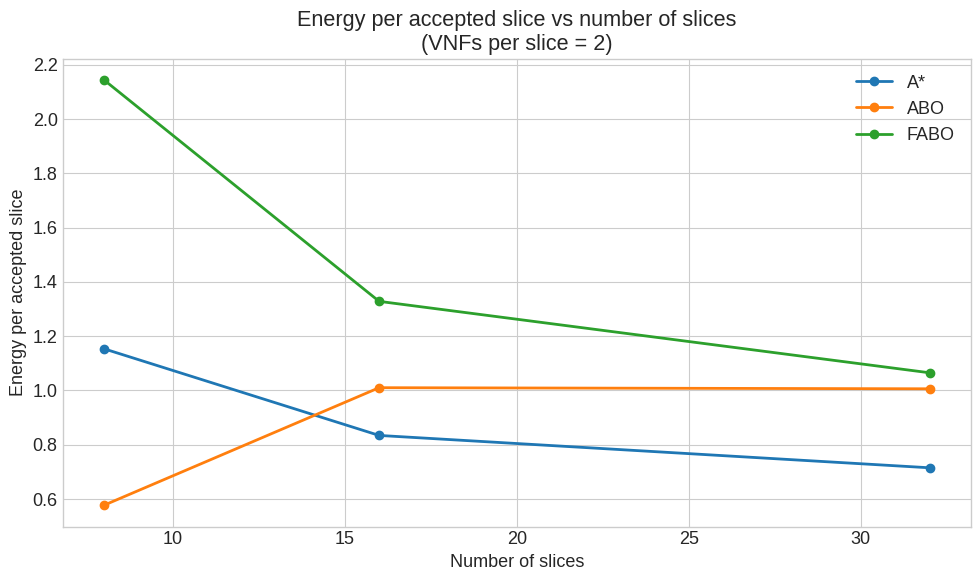

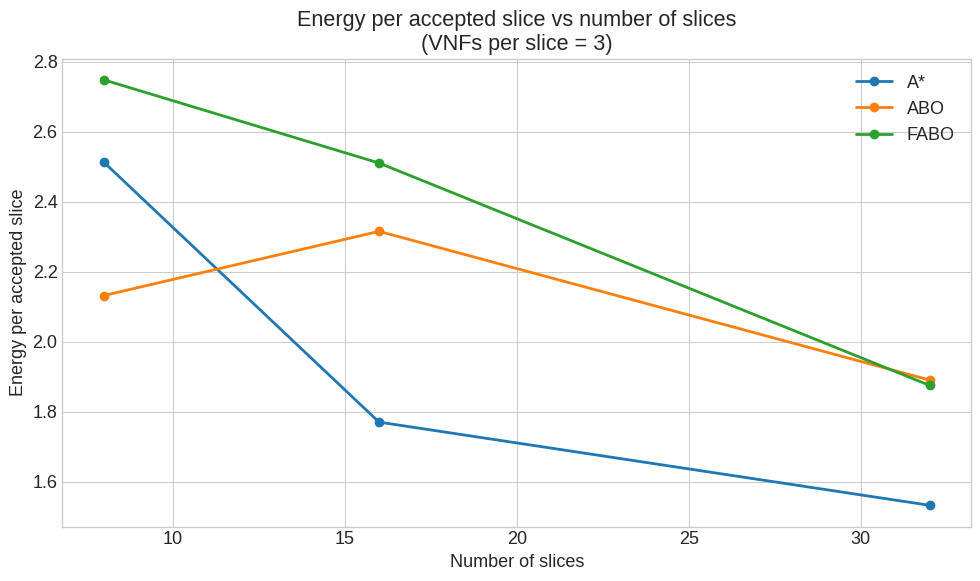

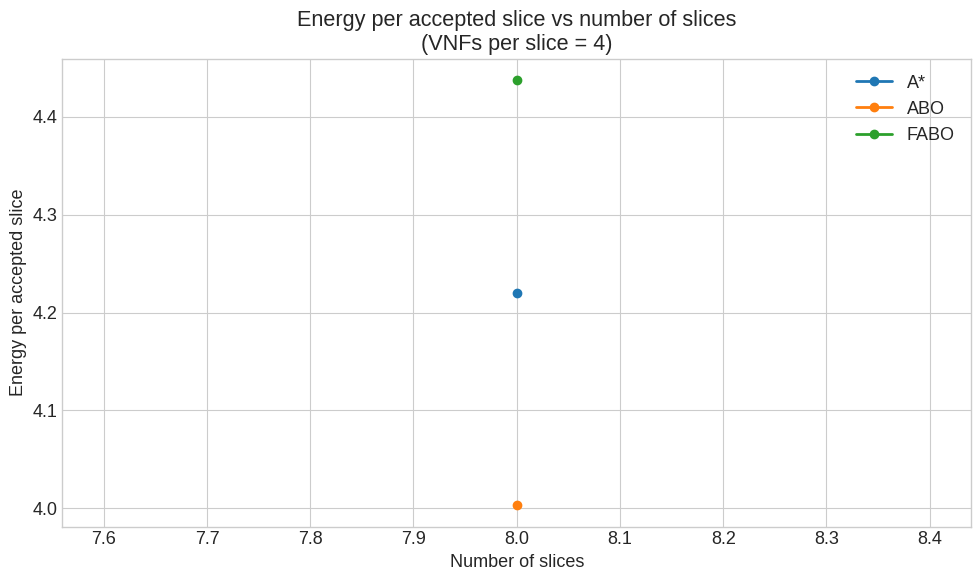

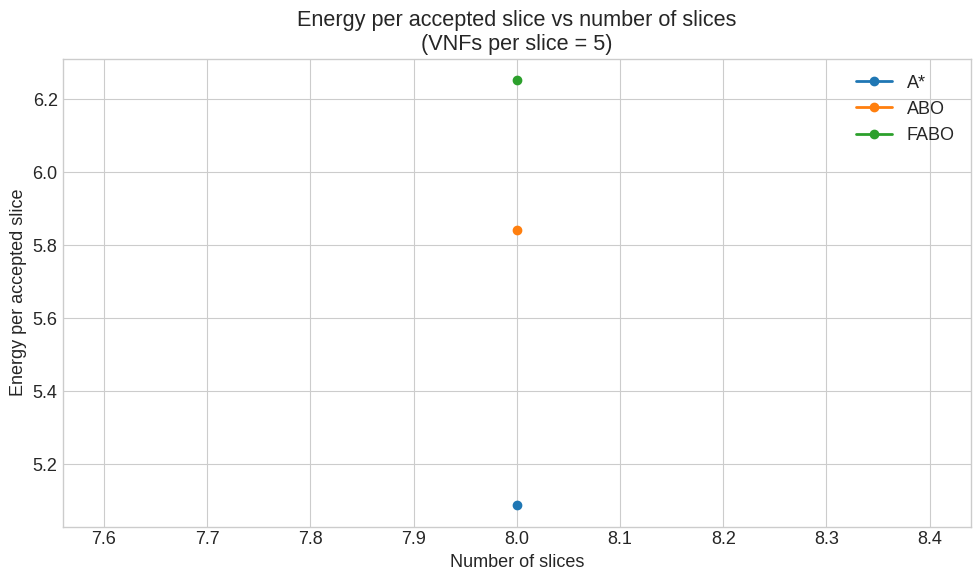

[WARN] No 100% acceptance scenarios for 6 VNFs — skipping.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 13

# ================================
# Load data
# ================================
df = pd.read_csv("./results/2025-12-12_08-27-50/scalability_results.csv")

methods = ["A*", "ABO", "FABO"]
df["acceptance_rate"] = df["accepted"] / df["num_slices"]
df["energy_per_slice"] = df["total_energy"] / df["accepted"]

# =======================================
# Find ALL valid (100% acceptance) scenarios
# =======================================
acc = (
    df[df["method"].isin(methods)]
    .groupby(["num_slices", "num_vnfs_per_slice", "seed", "method"])["acceptance_rate"]
    .max()
    .reset_index()
)

pivot_acc = acc.pivot(
    index=["num_slices", "num_vnfs_per_slice", "seed"],
    columns="method",
    values="acceptance_rate"
)

mask = (pivot_acc[["A*", "ABO", "FABO"]] >= 0.9999).all(axis=1)
full_ok = pivot_acc[mask].reset_index()

df_ok = df.merge(full_ok, on=["num_slices", "num_vnfs_per_slice", "seed"], how="inner")
df_ok = df_ok[df_ok["method"].isin(methods)]

# =======================================
# Unique VNF scenarios tested
# =======================================
vnf_values = sorted(df["num_vnfs_per_slice"].unique())

print("VNF scenarios detected:", vnf_values)

# =======================================
# Generate a plot for each VNF scenario
# =======================================
for vnf in vnf_values:

    df_v = df_ok[df_ok["num_vnfs_per_slice"] == vnf]

    if df_v.empty:
        print(f"[WARN] No 100% acceptance scenarios for {vnf} VNFs — skipping.")
        continue

    fig, ax = plt.subplots()

    for m in methods:
        sub = df_v[df_v["method"] == m]
        grouped = sub.groupby("num_slices")["energy_per_slice"].mean()

        ax.plot(grouped.index, grouped.values,
                marker="o", label=m, linewidth=2)

    ax.set_title(f"Energy per accepted slice vs number of slices\n(VNFs per slice = {vnf})")
    ax.set_xlabel("Number of slices")
    ax.set_ylabel("Energy per accepted slice")
    ax.legend()
    plt.tight_layout()
    plt.show()


[INFO] Valid scenarios for full acceptance: 40
[INFO] Saved figure → ./energy_std_plots/energy_mean_std_vnfs2.png


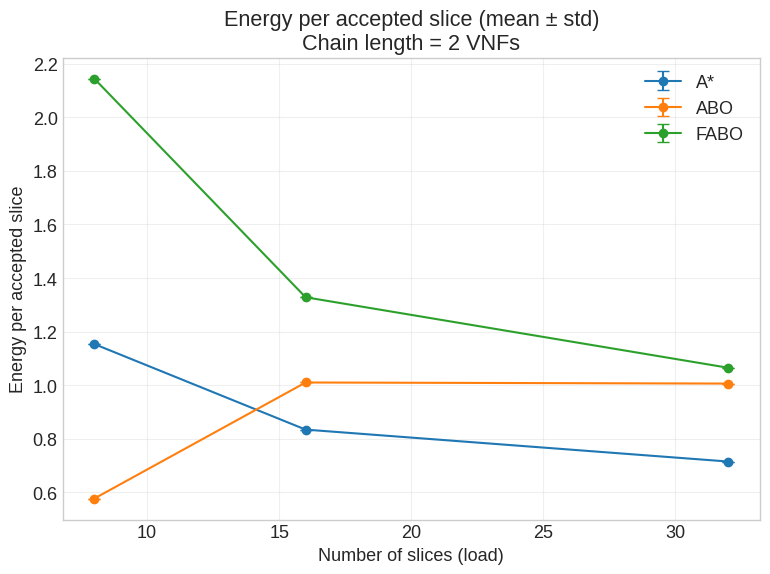

[INFO] Saved figure → ./energy_std_plots/energy_mean_std_vnfs3.png


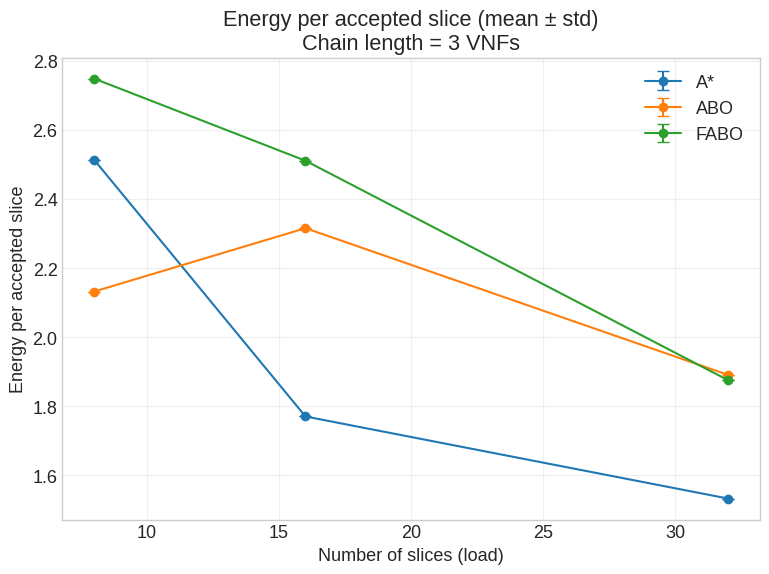

[INFO] Saved figure → ./energy_std_plots/energy_mean_std_vnfs4.png


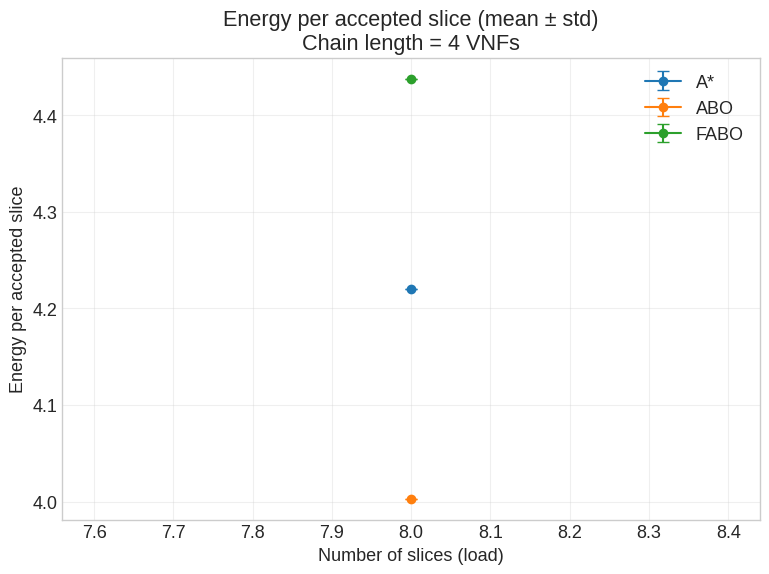

[INFO] Saved figure → ./energy_std_plots/energy_mean_std_vnfs5.png


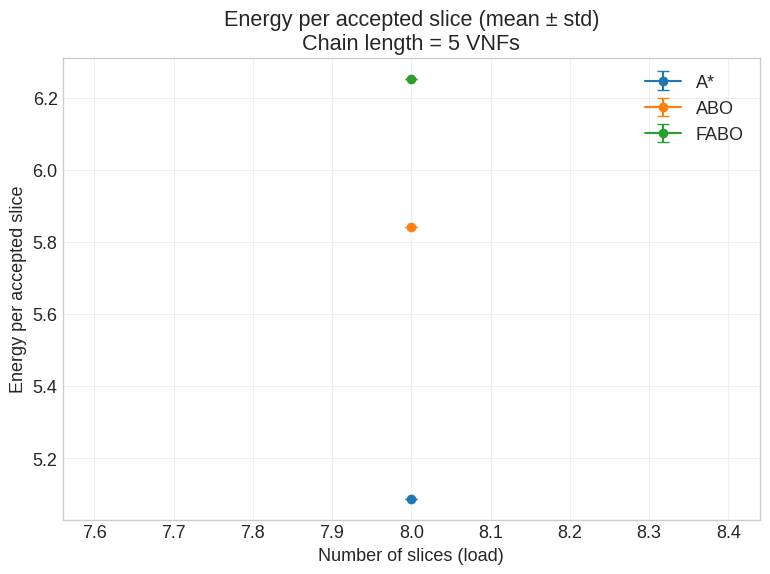

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load CSV
df = pd.read_csv("./results/2025-12-12_08-27-50/scalability_results.csv")

methods = ["A*", "ABO", "FABO"]

# Keep only relevant methods
df = df[df["method"].isin(methods)].copy()

# Compute acceptance rate
df["acceptance_rate"] = df["accepted"] / df["num_slices"]

# ============================================================
# FILTER: keep only scenarios where ALL 3 METHODS had 100%
# ============================================================

valid_scenarios = []

for (vnf_len, num_slices, seed), group in df.groupby(
    ["num_vnfs_per_slice", "num_slices", "seed"]
):
    acc_ok = True
    for m in methods:
        g = group[group["method"] == m]
        if g.empty or g["acceptance_rate"].iloc[0] < 1.0:
            acc_ok = False
            break
    if acc_ok:
        valid_scenarios.append((vnf_len, num_slices, seed))

print(f"[INFO] Valid scenarios for full acceptance:", len(valid_scenarios))

# Filter df to only these full-acceptance scenarios
df_valid = df.set_index(["num_vnfs_per_slice", "num_slices", "seed"])
df_valid = df_valid.loc[valid_scenarios].reset_index()

# Compute energy per accepted slice
df_valid["energy_per_slice"] = df_valid["total_energy"] / df_valid["accepted"]


# ============================================================
# PLOT mean + std of energy per accepted slice
# ============================================================

out_dir = "./energy_std_plots"
os.makedirs(out_dir, exist_ok=True)

chain_lengths = sorted(df_valid["num_vnfs_per_slice"].unique())

for vnf_len in chain_lengths:
    df_v = df_valid[df_valid["num_vnfs_per_slice"] == vnf_len]

    plt.figure(figsize=(9, 6))

    for method in methods:
        d = df_v[df_v["method"] == method]

        # Compute mean and std over seeds
        grouped = (
            d.groupby("num_slices")["energy_per_slice"]
              .agg(["mean", "std"])
              .reset_index()
              .sort_values("num_slices")
        )

        plt.errorbar(
            grouped["num_slices"],
            grouped["mean"],
            yerr=grouped["std"],
            marker="o",
            capsize=4,
            label=method
        )

    plt.title(f"Energy per accepted slice (mean ± std)\nChain length = {vnf_len} VNFs")
    plt.xlabel("Number of slices (load)")
    plt.ylabel("Energy per accepted slice")
    plt.grid(True, alpha=0.3)
    plt.legend()

    out_path = os.path.join(out_dir, f"energy_mean_std_vnfs{vnf_len}.png")
    plt.savefig(out_path, dpi=300)
    print(f"[INFO] Saved figure → {out_path}")

    plt.show()


[INFO] Valid scenarios with 100% acceptance for A*, ABO, FABO: 40
[INFO] Saved figure → ./energy_total_full_acceptance_plots/total_energy_full_accept_vnfs2.png


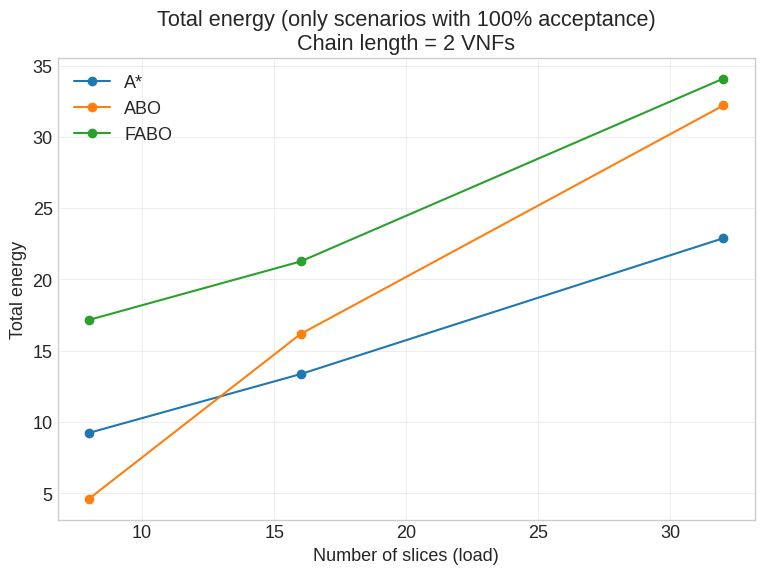

[INFO] Saved figure → ./energy_total_full_acceptance_plots/total_energy_full_accept_vnfs3.png


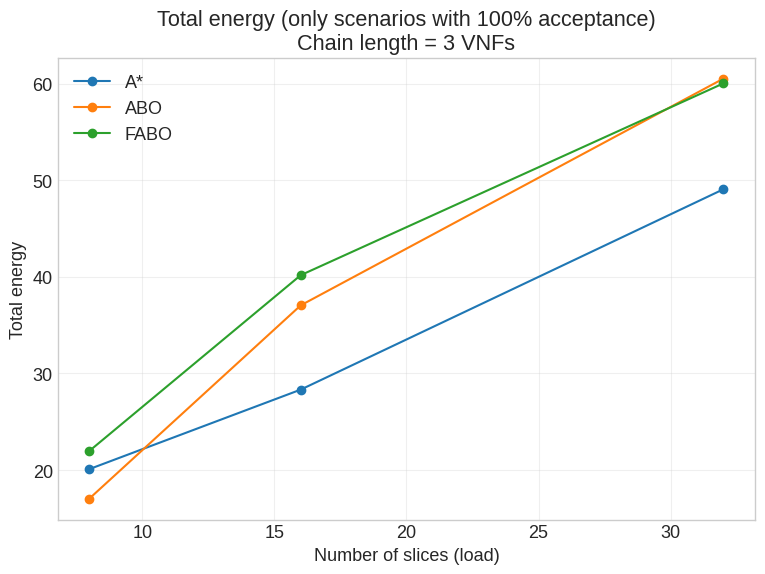

[INFO] Saved figure → ./energy_total_full_acceptance_plots/total_energy_full_accept_vnfs4.png


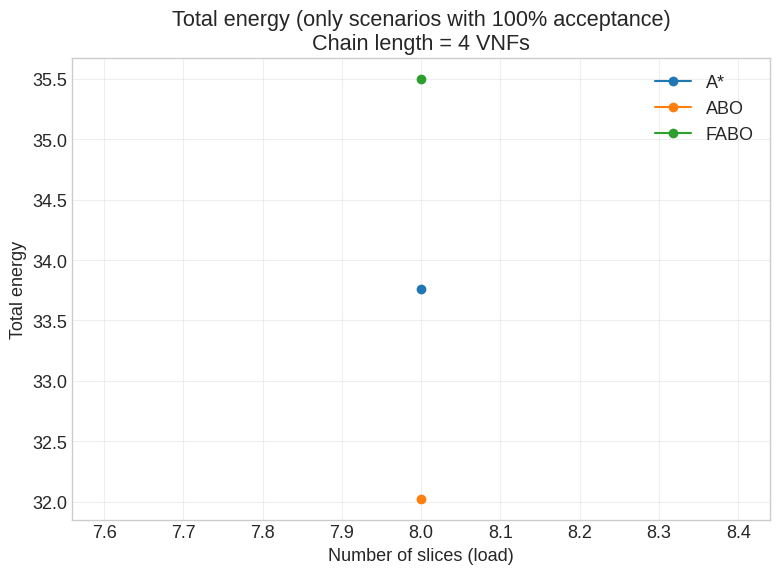

[INFO] Saved figure → ./energy_total_full_acceptance_plots/total_energy_full_accept_vnfs5.png


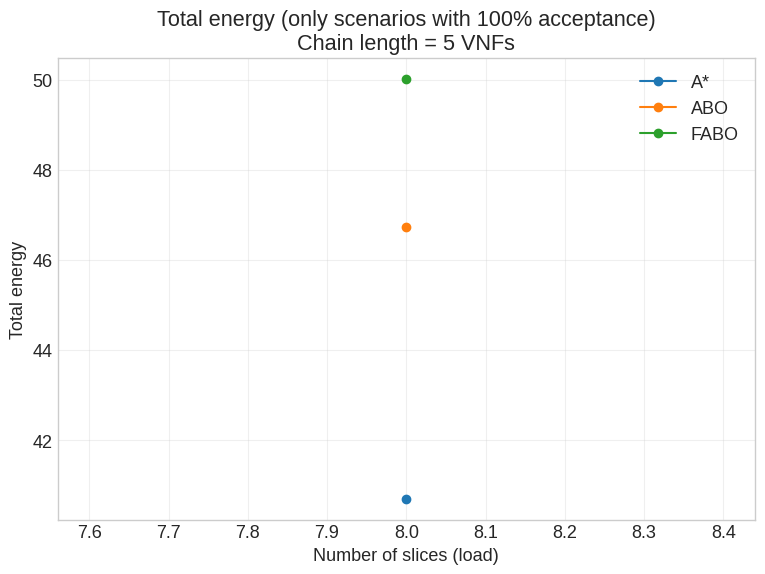

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ==============================
# Load results
# ==============================
results_path = "./results/2025-12-12_08-27-50/scalability_results.csv"  # ajuste se precisar
df = pd.read_csv(results_path)

methods = ["A*", "ABO", "FABO"]

# Fica só com A*, ABO, FABO
df = df[df["method"].isin(methods)].copy()

# Taxa de aceitação
df["acceptance_rate"] = df["accepted"] / df["num_slices"]

# ============================================================
# 1) Filtrar cenários onde TODOS os 3 métodos têm 100% de aceitação
#    (por num_vnfs_per_slice, num_slices, seed)
# ============================================================

valid_scenarios = []

for (vnf_len, num_slices, seed), group in df.groupby(
    ["num_vnfs_per_slice", "num_slices", "seed"]
):
    all_ok = True
    for m in methods:
        g = group[group["method"] == m]
        if g.empty or g["acceptance_rate"].iloc[0] < 1.0:
            all_ok = False
            break
    if all_ok:
        valid_scenarios.append((vnf_len, num_slices, seed))

print(f"[INFO] Valid scenarios with 100% acceptance for A*, ABO, FABO: {len(valid_scenarios)}")

# Filtra só esses cenários
df_valid = df.set_index(["num_vnfs_per_slice", "num_slices", "seed"])
df_valid = df_valid.loc[valid_scenarios].reset_index()

# ============================================================
# 2) Gráfico de ENERGIA TOTAL por cenário (média sobre seeds)
#    - um gráfico por tamanho de cadeia (num_vnfs_per_slice)
#    - eixo X: num_slices (carga)
#    - eixo Y: energia total
# ============================================================

out_dir = "./energy_total_full_acceptance_plots"
os.makedirs(out_dir, exist_ok=True)

chain_lengths = sorted(df_valid["num_vnfs_per_slice"].unique())

for vnf_len in chain_lengths:
    df_v = df_valid[df_valid["num_vnfs_per_slice"] == vnf_len]

    if df_v.empty:
        print(f"[WARN] No valid scenarios for chain length = {vnf_len}")
        continue

    plt.figure(figsize=(9, 6))

    for method in methods:
        d = df_v[df_v["method"] == method]

        if d.empty:
            continue

        # média da energia total sobre seeds, por num_slices
        grouped = (
            d.groupby("num_slices")["total_energy"]
             .mean()
             .reset_index()
             .sort_values("num_slices")
        )

        plt.plot(
            grouped["num_slices"],
            grouped["total_energy"],
            marker="o",
            label=method
        )

    plt.title(f"Total energy (only scenarios with 100% acceptance)\nChain length = {vnf_len} VNFs")
    plt.xlabel("Number of slices (load)")
    plt.ylabel("Total energy")
    plt.grid(True, alpha=0.3)
    plt.legend()

    out_path = os.path.join(out_dir, f"total_energy_full_accept_vnfs{vnf_len}.png")
    plt.savefig(out_path, dpi=300)
    print(f"[INFO] Saved figure → {out_path}")

    plt.show()


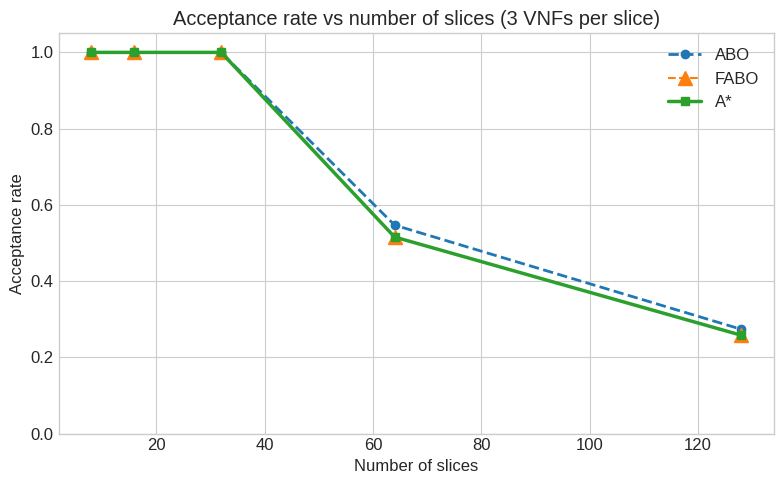

In [ ]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.size"] = 12

fig, ax = plt.subplots()

styles = {
    "ABO":  dict(marker="o", linestyle="--", linewidth=2),
    "FABO": dict(marker="^", linestyle="--", markersize=10),  # só marcadores
    "A*":   dict(marker="s", linestyle="-", linewidth=2.5),
}

target_methods = ["ABO", "FABO", "A*"]


for method in target_methods:
    sub = grouped_acc[grouped_acc["method"] == method]
    if sub.empty:
        continue

    style = styles.get(method, {})
    ax.plot(
        sub["num_slices"],
        sub["mean"],
        label=method,
        **style,
    )

ax.set_xlabel("Number of slices")
ax.set_ylabel("Acceptance rate")
ax.set_title("Acceptance rate vs number of slices (3 VNFs per slice)")
ax.set_ylim(0, 1.05)
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

df = pd.read_csv("./results/2025-12-12_08-27-50/scalability_results.csv")

# Foca nos cenários de 2 VNFs
df2 = df[df["num_vnfs_per_slice"] == 3].copy()

# Pivot: aceitação por método, load e seed
pivot = df2.pivot_table(
    index=["num_slices", "seed"],
    columns="method",
    values="accepted",
    aggfunc="max",
).sort_index()

display(pivot)

# Linhas onde ABO < A*
problem = pivot[pivot["ABO"] > pivot["A*"]]
print("Cenários em que ABO aceita mais que A*:")
display(problem)


method           A*  ABO  FABO
num_slices seed               
8          1      8    8     8
           2      8    8     8
           3      8    8     8
           4      8    8     8
           5      8    8     8
16         1     16   16    16
           2     16   16    16
           3     16   16    16
           4     16   16    16
           5     16   16    16
32         1     32   32    32
           2     32   32    32
           3     32   32    32
           4     32   32    32
           5     32   32    32
64         1     33   35    33
           2     33   35    33
           3     33   35    33
           4     33   35    33
           5     33   35    33
128        1     33   35    33
           2     33   35    33
           3     33   35    33
           4     33   35    33
           5     33   35    33

Cenários em que ABO aceita mais que A*:


method           A*  ABO  FABO
num_slices seed               
64         1     33   35    33
           2     33   35    33
           3     33   35    33
           4     33   35    33
           5     33   35    33
128        1     33   35    33
           2     33   35    33
           3     33   35    33
           4     33   35    33
           5     33   35    33

In [ ]:
import pandas as pd

df = pd.read_csv("./results/2025-12-12_08-27-50/scalability_results.csv")

for vnf_len in [2, 3]:
    print(f"\n=== num_vnfs_per_slice = {vnf_len} ===")
    sub = df[df["num_vnfs_per_slice"] == vnf_len]
    pivot = sub.pivot_table(
        index=["num_slices", "seed"],
        columns="method",
        values="accepted",
        aggfunc="max",
    ).sort_index()
    display(pivot)



=== num_vnfs_per_slice = 2 ===


method           A*  ABO  FABO
num_slices seed               
8          1      8    8     8
           2      8    8     8
           3      8    8     8
           4      8    8     8
           5      8    8     8
16         1     16   16    16
           2     16   16    16
           3     16   16    16
           4     16   16    16
           5     16   16    16
32         1     32   32    32
           2     32   32    32
           3     32   32    32
           4     32   32    32
           5     32   32    32
64         1     61   56    64
           2     61   56    64
           3     61   56    64
           4     61   56    64
           5     61   56    64
128        1     61   56    64
           2     61   56    64
           3     61   56    64
           4     61   56    64
           5     61   56    64


=== num_vnfs_per_slice = 3 ===


method           A*  ABO  FABO
num_slices seed               
8          1      8    8     8
           2      8    8     8
           3      8    8     8
           4      8    8     8
           5      8    8     8
16         1     16   16    16
           2     16   16    16
           3     16   16    16
           4     16   16    16
           5     16   16    16
32         1     32   32    32
           2     32   32    32
           3     32   32    32
           4     32   32    32
           5     32   32    32
64         1     33   35    33
           2     33   35    33
           3     33   35    33
           4     33   35    33
           5     33   35    33
128        1     33   35    33
           2     33   35    33
           3     33   35    33
           4     33   35    33
           5     33   35    33

In [ ]:
df["acceptance_rate_check"] = df["accepted"] / df["num_slices"]
(df["acceptance_rate"] - df["acceptance_rate_check"]).abs().max()


In [ ]:
from utils.topology import topologie_finlande
from utils.generate_slices import generate_random_slices
from heuristics.a_star import run_astar
from heuristics.run_abo_full_batch import run_abo_full_batch
from utils.metrics import count_accepted_slices     
G = topologie_finlande()
ENTRY = 6
node_capacity_base = {n: G.nodes[n]["cpu"] for n in G.nodes}
link_capacity_base = {(u, v): G[u][v]["bandwidth"] for u, v in G.edges}
link_capacity_base.update({(v, u): G[u][v]["bandwidth"] for u, v in G.edges})
link_latency = {(u, v): G[u][v]["latency"] for u, v in G.edges}
link_latency.update({(v, u): G[u][v]["latency"] for u, v in G.edges})

vnf_profiles = [
    {"cpu": 2,  "throughput": 30, "latency": 80},
    {"cpu": 3,  "throughput": 40, "latency": 110},
    {"cpu": 4,  "throughput": 50, "latency": 140},
    {"cpu": 6,  "throughput": 65, "latency": 180},
    {"cpu": 8,  "throughput": 80, "latency": 220},
    {"cpu": 10, "throughput": 95, "latency": 260},
]

num_vnfs = 2
num_slices = 32
seed = 1  # ou o seed suspeito

import random, numpy as np
random.seed(seed)
np.random.seed(seed)

slice_pool = generate_random_slices(
    G, vnf_profiles, num_slices=num_slices,
    num_vnfs_per_slice=num_vnfs, entry=ENTRY,
)
slices = slice_pool  # já no tamanho certo

astar_df, astar_res = run_astar(G, slices, node_capacity_base, link_capacity_base)
abo_df,   abo_res   = run_abo_full_batch(G, slices, node_capacity_base, link_latency, link_capacity_base)

print("A* accepted:", count_accepted_slices(astar_res, slices))
print("ABO accepted:", count_accepted_slices(abo_res, slices))


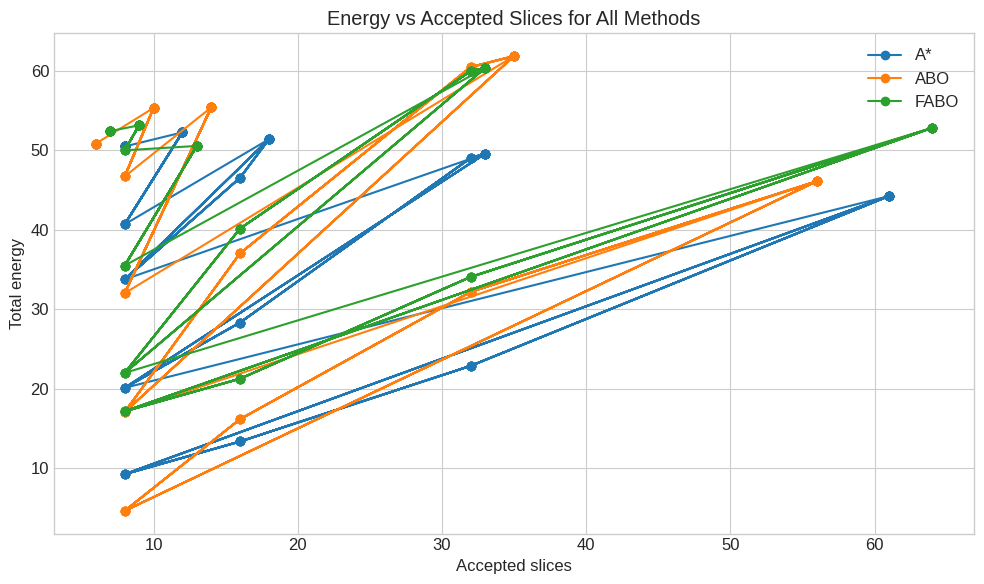

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Find latest results directory
results_base = "./results"
dirs = [d for d in os.listdir(results_base) if os.path.isdir(os.path.join(results_base, d))]
if not dirs:
    raise RuntimeError("No results found in ./results")

latest = sorted(dirs)[-1]
csv_path = os.path.join(results_base, latest, "scalability_results.csv")

df = pd.read_csv(csv_path)

# Prepare plot: total_energy vs accepted, grouped by method
methods = df["method"].unique()

plt.figure(figsize=(10,6))

for m in methods:
    sub = df[df["method"] == m]
    plt.plot(sub["accepted"], sub["total_energy"], marker="o", label=m)

plt.xlabel("Accepted slices")
plt.ylabel("Total energy")
plt.title("Energy vs Accepted Slices for All Methods")
plt.legend()
plt.tight_layout()

plt.show()


[INFO] Rows after filtering VNFs and methods: 75
[INFO] Rows after filtering 100% acceptance: 45


timestamp  num_slices  num_vnfs_per_slice  total_vnfs  seed  \
75  2025-12-12 08:44:31           8                   3          24     1   
76  2025-12-12 08:44:31           8                   3          24     1   
77  2025-12-12 08:44:31           8                   3          24     1   
78  2025-12-12 08:45:50          16                   3          48     1   
79  2025-12-12 08:45:50          16                   3          48     1   

   method  accepted  total_energy  total_bandwidth  total_latency  \
75     A*         8     20.107500            560.0           16.0   
76    ABO         8     17.057500            560.0           24.0   
77   FABO         8     21.987500            560.0           24.0   
78     A*        16     28.331875           1150.0           33.0   
79    ABO        16     37.049375           1180.0           54.0   

    runtime_sec  acceptance_rate  
75     0.371497              1.0  
76    26.857719              1.0  
77    23.296439              1.0  
78     0.686584              1.0  
79    38.754612              1.0


=== Accepted slices vs num_slices (100% acceptance, VNFs=3) ===


method        A*   ABO  FABO
num_slices                  
8            8.0   8.0   8.0
16          16.0  16.0  16.0
32          32.0  32.0  32.0


=== Total energy vs num_slices (100% acceptance, VNFs=3) ===


method             A*        ABO       FABO
num_slices                                 
8           20.107500  17.057500  21.987500
16          28.331875  37.049375  40.171875
32          49.061250  60.509375  60.016250

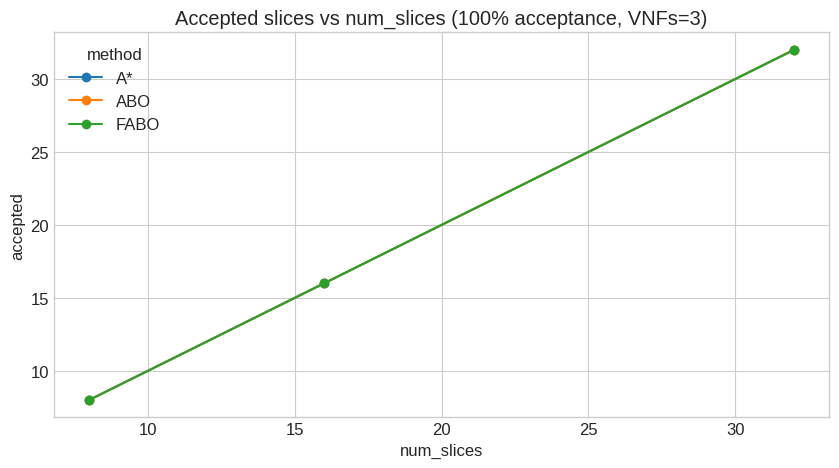

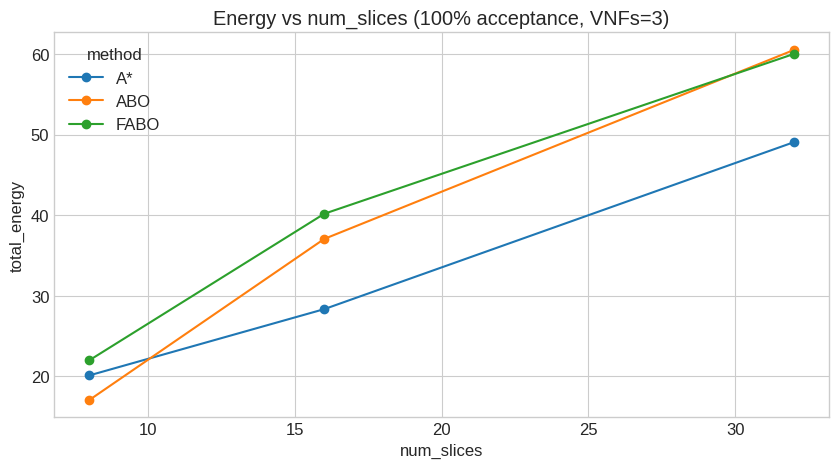

In [ ]:
import pandas as pd

# Load CSV
df_results = pd.read_csv("./results/2025-12-12_08-27-50/scalability_results.csv")

# Number of VNFs per slice you want to analyze
vnf_len = 3   # change to 2,3,4,5,6…

# Filter only this VNF chain length
df_exp = df_results[df_results["num_vnfs_per_slice"] == vnf_len].copy()

# Keep only the three heuristic methods
METHODS_ALLOWED = ["A*", "ABO", "FABO"]
df_exp = df_exp[df_exp["method"].isin(METHODS_ALLOWED)].copy()

print("[INFO] Rows after filtering VNFs and methods:", len(df_exp))

# Acceptance rate
df_exp["acceptance_rate"] = df_exp["accepted"] / df_exp["num_slices"]

# Keep only scenarios with 100% acceptance
df_ok = df_exp[df_exp["acceptance_rate"] == 1.0].copy()

print("[INFO] Rows after filtering 100% acceptance:", len(df_ok))
display(df_ok.head())

# ==============================
# 1) Accepted slices vs num_slices (100% acceptance)
# ==============================

pivot_acc = df_ok.pivot_table(
    index="num_slices",
    columns="method",
    values="accepted",
    aggfunc="mean",
).sort_index()

print(f"\n=== Accepted slices vs num_slices (100% acceptance, VNFs={vnf_len}) ===")
display(pivot_acc)

# ==============================
# 2) Total energy vs num_slices (100% acceptance)
# ==============================

pivot_energy = df_ok.pivot_table(
    index="num_slices",
    columns="method",
    values="total_energy",
    aggfunc="mean",
).sort_index()

print(f"\n=== Total energy vs num_slices (100% acceptance, VNFs={vnf_len}) ===")
display(pivot_energy)

# ==============================
# PLOTS
# ==============================

import matplotlib.pyplot as plt

# Accepted slices plot
try:
    ax = pivot_acc.plot(
        marker="o",
        figsize=(10, 5),
        title=f"Accepted slices vs num_slices (100% acceptance, VNFs={vnf_len})"
    )
    ax.set_xlabel("num_slices")
    ax.set_ylabel("accepted")
except Exception as e:
    print("[WARN] Could not plot acceptance:", e)

# Energy plot
try:
    ax = pivot_energy.plot(
        marker="o",
        figsize=(10, 5),
        title=f"Energy vs num_slices (100% acceptance, VNFs={vnf_len})"
    )
    ax.set_xlabel("num_slices")
    ax.set_ylabel("total_energy")
except Exception as e:
    print("[WARN] Could not plot energy:", e)


In [ ]:
# ============================
# Imports (clean and complete)
# ============================

import os
import time
import random
import numpy as np
import networkx as nx
import pandas as pd
from copy import deepcopy
from datetime import datetime
import re

from itertools import product
from tqdm import tqdm

# --- Safe filename function ---
def safe_filename(text):
    """Convert any string into a safe filename: no accents, spaces, or special chars."""
    text = text.lower()
    text = text.replace(" ", "_")
    text = re.sub(r"[^a-z0-9_\-]", "", text)
    return text

# --- Global reproducibility seed ---
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
os.environ["PYTHONHASHSEED"] = str(GLOBAL_SEED)

# --- MILP modules (not used if ENABLE_SEQ_MILP=False, you can keep or remove) ---
from milp.create_instance import create_instance
from milp.solve_gurobi_sequential import (
    solve_gurobi_sequential,
    _get_slice_vl_pairs,
    NODE_ENERGY_WEIGHT,
    LINK_ENERGY_WEIGHT,
)

# --- Topologies ---
from utils.topology import topologie_finlande, topology_brazil

# --- Slice generation ---
from utils.generate_slices import generate_random_slices

# --- Heuristics ---
from heuristics.a_star import run_astar
from heuristics.run_abo_full_batch import run_abo_full_batch
from heuristics.run_fabo_full_batch import run_fabo_full_batch
from heuristics.best_fit import run_best_fit
from heuristics.first_fit import run_first_fit
from heuristics.a_star_energy_aware import energy_aware_astar

# --- Metrics ---
from utils.metrics import (
    count_accepted_slices,
    compute_energy_new,
    compute_total_bandwidth,
    compute_total_latency,
)

# ============================
# Directories for results
# ============================

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_dir = os.path.join("./results", safe_filename(timestamp))
os.makedirs(results_dir, exist_ok=True)

print(f"[INFO] Results will be saved under: {results_dir}")

# ============================
# Global experiment parameters
# ============================

MILP_TIME_LIMIT = 300
ENTRY = 6
MAX_MILP_SLICES = 128
MAX_MILP_VNFS_TOTAL = 512

ENABLE_PLOTS = False       # no plots
ENABLE_SEQ_MILP = False    # skip sequential MILP

# --- Topology ---
G = topologie_finlande()
ENTRY = 6

# --- VNF profiles ---
vnf_profiles = [
    {"cpu": 2,  "throughput": 30, "latency": 80},   # light
    {"cpu": 3,  "throughput": 40, "latency": 110},  # slightly heavier
    {"cpu": 4,  "throughput": 50, "latency": 140},  # medium
    {"cpu": 6,  "throughput": 65, "latency": 180},  # medium-heavy
    {"cpu": 8,  "throughput": 80, "latency": 220},  # heavy
    {"cpu": 10, "throughput": 95, "latency": 260},  # very heavy
]

# --- Base capacities ---
node_capacity_base = {n: G.nodes[n]["cpu"] for n in G.nodes}
link_capacity_base = {(u, v): G[u][v]["bandwidth"] for u, v in G.edges}
link_capacity_base.update({(v, u): G[u][v]["bandwidth"] for u, v in G.edges})
link_latency = {(u, v): G[u][v]["latency"] for u, v in G.edges}
link_latency.update({(v, u): G[u][v]["latency"] for u, v in G.edges})

# --- Parameter grid (seeds 1 to 5) ---
param_grid = {
    "num_slices": [8, 16, 32, 64, 128],
    "num_vnfs_per_slice": [2, 3, 4, 5, 6],
    "seed": list(range(1, 6)),  # 1..5
}

max_slices = max(param_grid["num_slices"])

# Prepare list of all scenarios
scenario_list = list(product(
    param_grid["num_vnfs_per_slice"],
    param_grid["seed"],
    param_grid["num_slices"],
))
total_scenarios = len(scenario_list)
print(f"[INFO] Total scenarios: {total_scenarios}")

# Pre-generate slice pools per (num_vnfs, seed)
slice_pools = {}
for num_vnfs in param_grid["num_vnfs_per_slice"]:
    for seed in param_grid["seed"]:
        random.seed(seed)
        np.random.seed(seed)
        print(f"\n[INFO] === Pre-generating slice pool: max_slices={max_slices}, "
              f"VNFs={num_vnfs}, seed={seed} ===")

        slice_pool = generate_random_slices(
            G,
            vnf_profiles,
            num_slices=max_slices,
            num_vnfs_per_slice=num_vnfs,
            entry=ENTRY,
        )
        slice_pools[(num_vnfs, seed)] = slice_pool

# ============================
# Main experiment loop
# ============================

records = []

try:
    pbar = tqdm(total=total_scenarios, desc="Scenarios", unit="scenario")

    for (num_vnfs, seed, num_slices) in scenario_list:
        total_vnfs = num_slices * num_vnfs

        pbar.set_description(
            f"Scen: vnfs={num_vnfs}, seed={seed}, slices={num_slices}"
        )

        slice_pool = slice_pools[(num_vnfs, seed)]

        print(f"\n[INFO] === Running Load Test: {num_slices} slices × "
              f"{num_vnfs} VNFs (total={total_vnfs}), seed={seed} ===")

        slices = deepcopy(slice_pool[:num_slices])
        method_results = {}
        method_times = {}

        # --- Heuristics (only A*, ABO, FABO) ---
        heuristics_spec = [
            ("A*",   run_astar,          (G, slices, node_capacity_base, link_capacity_base)),
            ("ABO",  run_abo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
            ("FABO", run_fabo_full_batch,(G, slices, node_capacity_base, link_latency, link_capacity_base)),
        ]

        for name, func, args in heuristics_spec:
            start = time.time()
            try:
                df_res, res_list = func(*args)
                method_results[name] = res_list
            except Exception as e:
                print(f"[ERROR] {name} failed: {e}")
                method_results[name] = []
            method_times[name] = time.time() - start

        # --- Metrics for heuristics ---
        for method_name, result_list in method_results.items():
            if not result_list:
                continue
            try:
                accepted = count_accepted_slices(result_list, slices)
                total_energy = compute_energy_new(
                    result_list, slices, node_capacity_base, link_capacity_base
                )
                total_bw = sum(b for b in compute_total_bandwidth(result_list, slices) if b)
                total_lat = sum(l for l in compute_total_latency(result_list, link_latency) if l)

                records.append({
                    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    "num_slices": num_slices,
                    "num_vnfs_per_slice": num_vnfs,
                    "total_vnfs": total_vnfs,
                    "seed": seed,
                    "method": method_name,
                    "accepted": accepted,
                    "total_energy": total_energy,
                    "total_bandwidth": total_bw,
                    "total_latency": total_lat,
                    "runtime_sec": method_times[method_name],
                })
            except Exception as e:
                print(f"[ERROR] Metrics failed for {method_name}, "
                      f"slices={num_slices}, vnfs={num_vnfs}, seed={seed}: {e}")

        pbar.update(1)

finally:
    try:
        pbar.close()
    except:
        pass

    df_results = pd.DataFrame(records)

    if not df_results.empty:
        dup = df_results.groupby(["method", "num_slices", "num_vnfs_per_slice", "seed"]).size()
        print("[CHECK] Max repetitions:", dup.max())
    else:
        print("[WARN] df_results is empty, nothing to group.")

    output_path = os.path.join(results_dir, "scalability_results.csv")
    df_results.to_csv(output_path, index=False)
    print(f"\n[INFO] Results saved to {output_path}")
    print(f"[INFO] records generated: {len(records)}")
    print(f"[INFO] CSV exists? {os.path.exists(output_path)}")


In [ ]:
# ============================
# Full experiment cell (A*, ABO, FABO only)
# ============================

import os
import time
import random
import numpy as np
import networkx as nx
import pandas as pd
from copy import deepcopy
from datetime import datetime
import re

from itertools import product
from tqdm import tqdm

# ----------------------------
# Helper: safe filename
# ----------------------------
def safe_filename(text):
    """Convert any string into a safe filename: no accents, spaces, or special chars."""
    text = text.lower()
    text = text.replace(" ", "_")
    text = re.sub(r"[^a-z0-9_\-]", "", text)
    return text

# ----------------------------
# Global reproducibility seed
# ----------------------------
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
os.environ["PYTHONHASHSEED"] = str(GLOBAL_SEED)

# ----------------------------
# Imports from project
# ----------------------------
# Topology
from utils.topology import topologie_finlande

# Slice generation
from utils.generate_slices import generate_random_slices

# Heuristics
from heuristics.a_star import run_astar
from heuristics.run_abo_full_batch import run_abo_full_batch
from heuristics.run_fabo_full_batch import run_fabo_full_batch

# Metrics
from utils.metrics import (
    count_accepted_slices,
    compute_energy_new,
    compute_total_bandwidth,
    compute_total_latency,
)

# ----------------------------
# Directories for results
# ----------------------------
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_dir = os.path.join("./results", safe_filename(timestamp))
os.makedirs(results_dir, exist_ok=True)

print(f"[INFO] Results will be saved under: {results_dir}")

# ----------------------------
# Global experiment parameters
# ----------------------------
ENTRY = 6

# Topology
G = topologie_finlande()
ENTRY = 6

# VNF profiles (must match the ones used before)
vnf_profiles = [
    {"cpu": 2,  "throughput": 30, "latency": 80},   # light
    {"cpu": 3,  "throughput": 40, "latency": 110},  # slightly heavier
    {"cpu": 4,  "throughput": 50, "latency": 140},  # medium
    {"cpu": 6,  "throughput": 65, "latency": 180},  # medium-heavy
    {"cpu": 8,  "throughput": 80, "latency": 220},  # heavy
    {"cpu": 10, "throughput": 95, "latency": 260},  # very heavy
]

# Base capacities from graph
node_capacity_base = {n: G.nodes[n]["cpu"] for n in G.nodes}
link_capacity_base = {(u, v): G[u][v]["bandwidth"] for u, v in G.edges}
link_capacity_base.update({(v, u): G[u][v]["bandwidth"] for u, v in G.edges})
link_latency = {(u, v): G[u][v]["latency"] for u, v in G.edges}
link_latency.update({(v, u): G[u][v]["latency"] for u, v in G.edges})

# ----------------------------
# Parameter grid (seeds 1..5)
# ----------------------------
param_grid = {
    "num_slices": [8, 16, 32, 64, 128],
    "num_vnfs_per_slice": [2, 3, 4, 5, 6],
    "seed": list(range(1, 5 + 1)),  # 1..5
}

max_slices = max(param_grid["num_slices"])

# Build full list of scenarios (num_vnfs, seed, num_slices)
scenario_list = list(product(
    param_grid["num_vnfs_per_slice"],
    param_grid["seed"],
    param_grid["num_slices"],
))
total_scenarios = len(scenario_list)
print(f"[INFO] Total scenarios: {total_scenarios}")

# ----------------------------
# Pre-generate slice pools per (num_vnfs, seed)
# ----------------------------
slice_pools = {}

for num_vnfs in param_grid["num_vnfs_per_slice"]:
    for seed in param_grid["seed"]:
        random.seed(seed)
        np.random.seed(seed)

        print(f"\n[INFO] === Pre-generating slice pool: max_slices={max_slices}, "
              f"VNFs={num_vnfs}, seed={seed} ===")

        slice_pool = generate_random_slices(
            G,
            vnf_profiles,
            num_slices=max_slices,
            num_vnfs_per_slice=num_vnfs,
            entry=ENTRY,
        )
        if len(slice_pool) < max_slices:
            print(f"[WARN] slice_pool has only {len(slice_pool)} entries (expected {max_slices}).")

        slice_pools[(num_vnfs, seed)] = slice_pool

# ----------------------------
# Main experiment loop (A*, ABO, FABO only)
# ----------------------------
records = []

try:
    pbar = tqdm(total=total_scenarios, desc="Scenarios", unit="scenario")

    for (num_vnfs, seed, num_slices) in scenario_list:
        total_vnfs = num_slices * num_vnfs

        pbar.set_description(
            f"Scen: vnfs={num_vnfs}, seed={seed}, slices={num_slices}"
        )

        slice_pool = slice_pools[(num_vnfs, seed)]

        print(f"\n[INFO] === Running Load Test: {num_slices} slices × "
              f"{num_vnfs} VNFs (total={total_vnfs}), seed={seed} ===")

        # Use first num_slices from the pre-generated pool
        slices = deepcopy(slice_pool[:num_slices])

        method_results = {}
        method_times = {}

        # Only the three heuristics we care about
        heuristics_spec = [
            ("A*",   run_astar,          (G, slices, node_capacity_base, link_capacity_base)),
            ("ABO",  run_abo_full_batch, (G, slices, node_capacity_base, link_latency, link_capacity_base)),
            ("FABO", run_fabo_full_batch,(G, slices, node_capacity_base, link_latency, link_capacity_base)),
        ]

        # Run heuristics
        for name, func, args in heuristics_spec:
            start = time.time()
            try:
                df_res, res_list = func(*args)
                method_results[name] = res_list
            except Exception as e:
                print(f"[ERROR] {name} failed: {e}")
                method_results[name] = []
            method_times[name] = time.time() - start

        # Collect metrics for each method
        for method_name, result_list in method_results.items():
            if not result_list:
                continue
            try:
                accepted = count_accepted_slices(result_list, slices)
                total_energy = compute_energy_new(
                    result_list, slices, node_capacity_base, link_capacity_base
                )
                total_bw = sum(b for b in compute_total_bandwidth(result_list, slices) if b)
                total_lat = sum(l for l in compute_total_latency(result_list, link_latency) if l)

                records.append({
                    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    "num_slices": num_slices,
                    "num_vnfs_per_slice": num_vnfs,
                    "total_vnfs": total_vnfs,
                    "seed": seed,
                    "method": method_name,
                    "accepted": accepted,
                    "total_energy": total_energy,
                    "total_bandwidth": total_bw,
                    "total_latency": total_lat,
                    "runtime_sec": method_times[method_name],
                })
            except Exception as e:
                print(f"[ERROR] Metrics failed for {method_name}, "
                      f"slices={num_slices}, vnfs={num_vnfs}, seed={seed}: {e}")

        pbar.update(1)

finally:
    try:
        pbar.close()
    except:
        pass

    df_results = pd.DataFrame(records)

    if not df_results.empty:
        dup = df_results.groupby(["method", "num_slices", "num_vnfs_per_slice", "seed"]).size()
        print("[CHECK] Max repetitions:", dup.max())
    else:
        print("[WARN] df_results is empty, nothing to group.")

    output_path = os.path.join(results_dir, "scalability_results.csv")
    df_results.to_csv(output_path, index=False)
    print(f"\n[INFO] Results saved to {output_path}")
    print(f"[INFO] records generated: {len(records)}")
    print(f"[INFO] CSV exists? {os.path.exists(output_path)}")


[INFO] Results will be saved under: ./results/2025-12-12_08-27-50
[INFO] Total scenarios: 125

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=2, seed=1 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=2, seed=2 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=2, seed=3 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=2, seed=4 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=2, seed=5 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=3, seed=1 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=3, seed=2 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=3, seed=3 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=3, seed=4 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=3, seed=5 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=4, seed=1 ===

[INFO] === Pre-generating slice pool: max_slices=128, VNFs=4, seed=2 ===

[INFO] === Pre-ge

Scen: vnfs=2, seed=1, slices=8:   0%|          | 0/125 [00:00<?, ?scenario/s]


[INFO] === Running Load Test: 8 slices × 2 VNFs (total=16), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 7 accepted.


[INFO][A*]

Scen: vnfs=2, seed=1, slices=16:   1%|          | 1/125 [00:14<29:15, 14.16s/scenario]

[INFO][FABO] Found feasible solution after 10 states.
[SUMMARY][FABO] Slice 8 accepted. min_node_cpu=10, links_low_bw=0

[INFO] === Running Load Test: 16 slices × 2 VNFs (total=32), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solvi

Scen: vnfs=2, seed=1, slices=32:   2%|▏         | 2/125 [00:40<44:19, 21.62s/scenario]

[INFO][FABO] Found feasible solution after 10 states.
[SUMMARY][FABO] Slice 16 accepted. min_node_cpu=4, links_low_bw=0

[INFO] === Running Load Test: 32 slices × 2 VNFs (total=64), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solvi

Scen: vnfs=2, seed=1, slices=64:   2%|▏         | 3/125 [01:24<1:04:26, 31.69s/scenario]

[INFO][FABO] Found feasible solution after 8 states.
[SUMMARY][FABO] Slice 32 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 64 slices × 2 VNFs (total=128), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solvi

Scen: vnfs=2, seed=1, slices=128:   3%|▎         | 4/125 [02:16<1:20:05, 39.72s/scenario]

[INFO][FABO] Found feasible solution after 3 states.
[SUMMARY][FABO] Slice 63 accepted. min_node_cpu=0, links_low_bw=0

[INFO][FABO] === Solving slice 64 (2 VNFs, 1 VLs) ===
[INFO][FABO] Found feasible solution after 3 states.
[SUMMARY][FABO] Slice 64 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 128 slices × 2 VNFs (total=256), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][

Scen: vnfs=2, seed=2, slices=8:   4%|▍         | 5/125 [03:10<1:29:21, 44.68s/scenario]  

[SUMMARY][FABO] Slice 111 rejected.

[INFO][FABO] === Solving slice 112 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 112 rejected.

[INFO][FABO] === Solving slice 113 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 113 rejected.

[INFO][FABO] === Solving slice 114 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 114 rejected.

[INFO][FABO] === Solving slice 115 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 115 rejected.

[INFO][FABO] === Solving slice 116 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 116 rejected.

[INFO][FABO] === Solving slice 117 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 117 rejected.

[INFO][FABO] === Solving slice 118 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 118 rejected.

[INFO][FABO] === Solving slice 119 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 119 rejected.

[INFO][FABO] === Solving slice 120 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 120 rejected.

[INFO][FABO] === Solving slice 121 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 121 rejected.

[INFO][FABO] === Solving slice 122 (2 VNFs,

Scen: vnfs=2, seed=2, slices=16:   5%|▍         | 6/125 [03:24<1:08:03, 34.31s/scenario]

[INFO][FABO] Found feasible solution after 10 states.
[SUMMARY][FABO] Slice 8 accepted. min_node_cpu=10, links_low_bw=0

[INFO] === Running Load Test: 16 slices × 2 VNFs (total=32), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solvi

Scen: vnfs=2, seed=2, slices=32:   6%|▌         | 7/125 [03:51<1:02:34, 31.82s/scenario]

[INFO][FABO] Found feasible solution after 10 states.
[SUMMARY][FABO] Slice 16 accepted. min_node_cpu=4, links_low_bw=0

[INFO] === Running Load Test: 32 slices × 2 VNFs (total=64), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solvi

Scen: vnfs=2, seed=2, slices=64:   6%|▋         | 8/125 [04:34<1:09:24, 35.60s/scenario]

[INFO][FABO] Found feasible solution after 8 states.
[SUMMARY][FABO] Slice 32 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 64 slices × 2 VNFs (total=128), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solvi

Scen: vnfs=2, seed=2, slices=128:   7%|▋         | 9/125 [05:26<1:18:47, 40.75s/scenario]

[INFO][FABO] Found feasible solution after 3 states.
[SUMMARY][FABO] Slice 63 accepted. min_node_cpu=0, links_low_bw=0

[INFO][FABO] === Solving slice 64 (2 VNFs, 1 VLs) ===
[INFO][FABO] Found feasible solution after 3 states.
[SUMMARY][FABO] Slice 64 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 128 slices × 2 VNFs (total=256), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][

Scen: vnfs=2, seed=3, slices=8:   8%|▊         | 10/125 [06:20<1:25:37, 44.67s/scenario]  

[SUMMARY][FABO] Slice 111 rejected.

[INFO][FABO] === Solving slice 112 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 112 rejected.

[INFO][FABO] === Solving slice 113 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 113 rejected.

[INFO][FABO] === Solving slice 114 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 114 rejected.

[INFO][FABO] === Solving slice 115 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 115 rejected.

[INFO][FABO] === Solving slice 116 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 116 rejected.

[INFO][FABO] === Solving slice 117 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 117 rejected.

[INFO][FABO] === Solving slice 118 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 118 rejected.

[INFO][FABO] === Solving slice 119 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 119 rejected.

[INFO][FABO] === Solving slice 120 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 120 rejected.

[INFO][FABO] === Solving slice 121 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 121 rejected.

[INFO][FABO] === Solving slice 122 (2 VNFs,

Scen: vnfs=2, seed=3, slices=16:   9%|▉         | 11/125 [06:34<1:07:05, 35.31s/scenario]

[INFO][FABO] Found feasible solution after 10 states.
[SUMMARY][FABO] Slice 8 accepted. min_node_cpu=10, links_low_bw=0

[INFO] === Running Load Test: 16 slices × 2 VNFs (total=32), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solvi

Scen: vnfs=2, seed=3, slices=32:  10%|▉         | 12/125 [07:01<1:01:36, 32.71s/scenario]

[INFO][FABO] Found feasible solution after 10 states.
[SUMMARY][FABO] Slice 16 accepted. min_node_cpu=4, links_low_bw=0

[INFO] === Running Load Test: 32 slices × 2 VNFs (total=64), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solvi

Scen: vnfs=2, seed=3, slices=64:  10%|█         | 13/125 [07:44<1:07:16, 36.04s/scenario]

[INFO][FABO] Found feasible solution after 8 states.
[SUMMARY][FABO] Slice 32 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 64 slices × 2 VNFs (total=128), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solvi

Scen: vnfs=2, seed=3, slices=128:  11%|█         | 14/125 [08:36<1:15:36, 40.87s/scenario]

[INFO][FABO] Found feasible solution after 3 states.
[SUMMARY][FABO] Slice 63 accepted. min_node_cpu=0, links_low_bw=0

[INFO][FABO] === Solving slice 64 (2 VNFs, 1 VLs) ===
[INFO][FABO] Found feasible solution after 3 states.
[SUMMARY][FABO] Slice 64 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 128 slices × 2 VNFs (total=256), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][

Scen: vnfs=2, seed=4, slices=8:  12%|█▏        | 15/125 [09:30<1:21:51, 44.65s/scenario]  

[SUMMARY][FABO] Slice 110 rejected.

[INFO][FABO] === Solving slice 111 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 111 rejected.

[INFO][FABO] === Solving slice 112 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 112 rejected.

[INFO][FABO] === Solving slice 113 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 113 rejected.

[INFO][FABO] === Solving slice 114 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 114 rejected.

[INFO][FABO] === Solving slice 115 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 115 rejected.

[INFO][FABO] === Solving slice 116 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 116 rejected.

[INFO][FABO] === Solving slice 117 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 117 rejected.

[INFO][FABO] === Solving slice 118 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 118 rejected.

[INFO][FABO] === Solving slice 119 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 119 rejected.

[INFO][FABO] === Solving slice 120 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 120 rejected.

[INFO][FABO] === Solving slice 121 (2 VNFs,

Scen: vnfs=2, seed=4, slices=16:  13%|█▎        | 16/125 [09:44<1:04:24, 35.45s/scenario]

[INFO][FABO] Found feasible solution after 10 states.
[SUMMARY][FABO] Slice 8 accepted. min_node_cpu=10, links_low_bw=0

[INFO] === Running Load Test: 16 slices × 2 VNFs (total=32), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solvi

Scen: vnfs=2, seed=4, slices=32:  14%|█▎        | 17/125 [10:11<59:04, 32.82s/scenario]  

[INFO][FABO] Found feasible solution after 10 states.
[SUMMARY][FABO] Slice 16 accepted. min_node_cpu=4, links_low_bw=0

[INFO] === Running Load Test: 32 slices × 2 VNFs (total=64), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solvi

Scen: vnfs=2, seed=4, slices=64:  14%|█▍        | 18/125 [10:54<1:04:22, 36.09s/scenario]

[INFO][FABO] Found feasible solution after 8 states.
[SUMMARY][FABO] Slice 32 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 64 slices × 2 VNFs (total=128), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solvi

Scen: vnfs=2, seed=4, slices=128:  15%|█▌        | 19/125 [11:46<1:12:14, 40.89s/scenario]

[INFO][FABO] Found feasible solution after 3 states.
[SUMMARY][FABO] Slice 62 accepted. min_node_cpu=0, links_low_bw=0

[INFO][FABO] === Solving slice 63 (2 VNFs, 1 VLs) ===
[INFO][FABO] Found feasible solution after 3 states.
[SUMMARY][FABO] Slice 63 accepted. min_node_cpu=0, links_low_bw=0

[INFO][FABO] === Solving slice 64 (2 VNFs, 1 VLs) ===
[INFO][FABO] Found feasible solution after 3 states.
[SUMMARY][FABO] Slice 64 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 128 slices × 2 VNFs (total=256), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] So

Scen: vnfs=2, seed=5, slices=8:  16%|█▌        | 20/125 [12:40<1:18:05, 44.62s/scenario]  

[SUMMARY][FABO] Slice 111 rejected.

[INFO][FABO] === Solving slice 112 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 112 rejected.

[INFO][FABO] === Solving slice 113 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 113 rejected.

[INFO][FABO] === Solving slice 114 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 114 rejected.

[INFO][FABO] === Solving slice 115 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 115 rejected.

[INFO][FABO] === Solving slice 116 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 116 rejected.

[INFO][FABO] === Solving slice 117 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 117 rejected.

[INFO][FABO] === Solving slice 118 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 118 rejected.

[INFO][FABO] === Solving slice 119 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 119 rejected.

[INFO][FABO] === Solving slice 120 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 120 rejected.

[INFO][FABO] === Solving slice 121 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 121 rejected.

[INFO][FABO] === Solving slice 122 (2 VNFs,

Scen: vnfs=2, seed=5, slices=16:  17%|█▋        | 21/125 [12:54<1:01:27, 35.45s/scenario]

[INFO][FABO] Found feasible solution after 10 states.
[SUMMARY][FABO] Slice 8 accepted. min_node_cpu=10, links_low_bw=0

[INFO] === Running Load Test: 16 slices × 2 VNFs (total=32), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solvi

Scen: vnfs=2, seed=5, slices=32:  18%|█▊        | 22/125 [13:20<56:22, 32.84s/scenario]  

[INFO][FABO] Found feasible solution after 10 states.
[SUMMARY][FABO] Slice 16 accepted. min_node_cpu=4, links_low_bw=0

[INFO] === Running Load Test: 32 slices × 2 VNFs (total=64), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solvi

Scen: vnfs=2, seed=5, slices=64:  18%|█▊        | 23/125 [14:04<1:01:24, 36.12s/scenario]

[INFO][FABO] Found feasible solution after 8 states.
[SUMMARY][FABO] Slice 32 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 64 slices × 2 VNFs (total=128), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solvi

Scen: vnfs=2, seed=5, slices=128:  19%|█▉        | 24/125 [14:56<1:08:50, 40.90s/scenario]

[INFO][FABO] Found feasible solution after 3 states.
[SUMMARY][FABO] Slice 63 accepted. min_node_cpu=0, links_low_bw=0

[INFO][FABO] === Solving slice 64 (2 VNFs, 1 VLs) ===
[INFO][FABO] Found feasible solution after 3 states.
[SUMMARY][FABO] Slice 64 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 128 slices × 2 VNFs (total=256), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=2, VLs=1) ===
[INFO][A*] Solution found after 6 expansions.
[SUMMARY][

Scen: vnfs=3, seed=1, slices=8:  20%|██        | 25/125 [15:50<1:14:27, 44.67s/scenario]  

[SUMMARY][FABO] Slice 114 rejected.

[INFO][FABO] === Solving slice 115 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 115 rejected.

[INFO][FABO] === Solving slice 116 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 116 rejected.

[INFO][FABO] === Solving slice 117 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 117 rejected.

[INFO][FABO] === Solving slice 118 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 118 rejected.

[INFO][FABO] === Solving slice 119 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 119 rejected.

[INFO][FABO] === Solving slice 120 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 120 rejected.

[INFO][FABO] === Solving slice 121 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 121 rejected.

[INFO][FABO] === Solving slice 122 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 122 rejected.

[INFO][FABO] === Solving slice 123 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 123 rejected.

[INFO][FABO] === Solving slice 124 (2 VNFs, 1 VLs) ===
[SUMMARY][FABO] Slice 124 rejected.

[INFO][FABO] === Solving slice 125 (2 VNFs,

Scen: vnfs=3, seed=1, slices=16:  21%|██        | 26/125 [16:40<1:16:36, 46.43s/scenario]

[INFO][FABO] Found feasible solution after 32 states.
[SUMMARY][FABO] Slice 8 accepted. min_node_cpu=2, links_low_bw=0

[INFO] === Running Load Test: 16 slices × 3 VNFs (total=48), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === 

Scen: vnfs=3, seed=1, slices=32:  22%|██▏       | 27/125 [18:00<1:32:00, 56.33s/scenario]

[INFO][FABO] Found feasible solution after 32 states.
[SUMMARY][FABO] Slice 16 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 32 slices × 3 VNFs (total=96), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] ===

Scen: vnfs=3, seed=1, slices=64:  22%|██▏       | 28/125 [19:30<1:47:30, 66.50s/scenario]

[INFO][FABO] Found feasible solution after 8 states.
[SUMMARY][FABO] Slice 32 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 64 slices × 3 VNFs (total=192), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] ===

Scen: vnfs=3, seed=1, slices=128:  23%|██▎       | 29/125 [21:04<1:59:26, 74.65s/scenario]

[SUMMARY][FABO] Slice 63 rejected.

[INFO][FABO] === Solving slice 64 (3 VNFs, 2 VLs) ===
[SUMMARY][FABO] Slice 64 rejected.

[INFO] === Running Load Test: 128 slices × 3 VNFs (total=384), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][

Scen: vnfs=3, seed=2, slices=8:  24%|██▍       | 30/125 [22:44<2:10:22, 82.34s/scenario]  

[SUMMARY][FABO] Slice 128 rejected.

[INFO] === Running Load Test: 8 slices × 3 VNFs (total=24), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[

Scen: vnfs=3, seed=2, slices=16:  25%|██▍       | 31/125 [23:34<1:54:02, 72.79s/scenario]

[INFO][FABO] Found feasible solution after 32 states.
[SUMMARY][FABO] Slice 8 accepted. min_node_cpu=2, links_low_bw=0

[INFO] === Running Load Test: 16 slices × 3 VNFs (total=48), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === 

Scen: vnfs=3, seed=2, slices=32:  26%|██▌       | 32/125 [24:54<1:55:54, 74.78s/scenario]

[INFO][FABO] Found feasible solution after 32 states.
[SUMMARY][FABO] Slice 16 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 32 slices × 3 VNFs (total=96), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] ===

Scen: vnfs=3, seed=2, slices=64:  26%|██▋       | 33/125 [26:24<2:01:43, 79.38s/scenario]

[INFO][FABO] Found feasible solution after 8 states.
[SUMMARY][FABO] Slice 32 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 64 slices × 3 VNFs (total=192), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] ===

Scen: vnfs=3, seed=2, slices=128:  27%|██▋       | 34/125 [27:58<2:06:54, 83.67s/scenario]

[SUMMARY][FABO] Slice 64 rejected.

[INFO] === Running Load Test: 128 slices × 3 VNFs (total=384), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.

Scen: vnfs=3, seed=3, slices=8:  28%|██▊       | 35/125 [29:38<2:12:57, 88.64s/scenario]  


[INFO] === Running Load Test: 8 slices × 3 VNFs (total=24), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 7 accepted.


[IN

Scen: vnfs=3, seed=3, slices=16:  29%|██▉       | 36/125 [30:28<1:54:33, 77.24s/scenario]

[INFO][FABO] Found feasible solution after 32 states.
[SUMMARY][FABO] Slice 8 accepted. min_node_cpu=2, links_low_bw=0

[INFO] === Running Load Test: 16 slices × 3 VNFs (total=48), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === 

Scen: vnfs=3, seed=3, slices=32:  30%|██▉       | 37/125 [31:48<1:54:20, 77.96s/scenario]

[INFO][FABO] Found feasible solution after 32 states.
[SUMMARY][FABO] Slice 16 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 32 slices × 3 VNFs (total=96), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] ===

Scen: vnfs=3, seed=3, slices=64:  30%|███       | 38/125 [33:18<1:58:22, 81.64s/scenario]

[INFO][FABO] Found feasible solution after 8 states.
[SUMMARY][FABO] Slice 32 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 64 slices × 3 VNFs (total=192), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] ===

Scen: vnfs=3, seed=3, slices=128:  31%|███       | 39/125 [34:52<2:02:10, 85.24s/scenario]

[SUMMARY][FABO] Slice 63 rejected.

[INFO][FABO] === Solving slice 64 (3 VNFs, 2 VLs) ===
[SUMMARY][FABO] Slice 64 rejected.

[INFO] === Running Load Test: 128 slices × 3 VNFs (total=384), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][

Scen: vnfs=3, seed=4, slices=8:  32%|███▏      | 40/125 [36:32<2:07:04, 89.70s/scenario]  

[SUMMARY][FABO] Slice 128 rejected.

[INFO] === Running Load Test: 8 slices × 3 VNFs (total=24), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[

Scen: vnfs=3, seed=4, slices=16:  33%|███▎      | 41/125 [37:23<1:49:08, 77.96s/scenario]

[INFO][FABO] Found feasible solution after 32 states.
[SUMMARY][FABO] Slice 8 accepted. min_node_cpu=2, links_low_bw=0

[INFO] === Running Load Test: 16 slices × 3 VNFs (total=48), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === 

Scen: vnfs=3, seed=4, slices=32:  34%|███▎      | 42/125 [38:42<1:48:27, 78.40s/scenario]

[INFO][FABO] Found feasible solution after 32 states.
[SUMMARY][FABO] Slice 16 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 32 slices × 3 VNFs (total=96), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] ===

Scen: vnfs=3, seed=4, slices=64:  34%|███▍      | 43/125 [40:12<1:51:58, 81.93s/scenario]

[INFO][FABO] Found feasible solution after 8 states.
[SUMMARY][FABO] Slice 32 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 64 slices × 3 VNFs (total=192), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] ===

Scen: vnfs=3, seed=4, slices=128:  35%|███▌      | 44/125 [41:46<1:55:27, 85.52s/scenario]

[SUMMARY][FABO] Slice 63 rejected.

[INFO][FABO] === Solving slice 64 (3 VNFs, 2 VLs) ===
[SUMMARY][FABO] Slice 64 rejected.

[INFO] === Running Load Test: 128 slices × 3 VNFs (total=384), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][

Scen: vnfs=3, seed=5, slices=8:  36%|███▌      | 45/125 [43:27<2:00:10, 90.13s/scenario]  

[SUMMARY][FABO] Slice 126 rejected.

[INFO][FABO] === Solving slice 127 (3 VNFs, 2 VLs) ===
[SUMMARY][FABO] Slice 127 rejected.

[INFO][FABO] === Solving slice 128 (3 VNFs, 2 VLs) ===
[SUMMARY][FABO] Slice 128 rejected.

[INFO] === Running Load Test: 8 slices × 3 VNFs (total=24), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) 

Scen: vnfs=3, seed=5, slices=16:  37%|███▋      | 46/125 [44:18<1:43:18, 78.47s/scenario]

[INFO][FABO] Found feasible solution after 32 states.
[SUMMARY][FABO] Slice 8 accepted. min_node_cpu=2, links_low_bw=0

[INFO] === Running Load Test: 16 slices × 3 VNFs (total=48), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === 

Scen: vnfs=3, seed=5, slices=32:  38%|███▊      | 47/125 [45:39<1:42:45, 79.05s/scenario]

[INFO][FABO] Found feasible solution after 32 states.
[SUMMARY][FABO] Slice 16 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 32 slices × 3 VNFs (total=96), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] ===

Scen: vnfs=3, seed=5, slices=64:  38%|███▊      | 48/125 [47:10<1:46:08, 82.70s/scenario]

[INFO][FABO] Found feasible solution after 8 states.
[SUMMARY][FABO] Slice 32 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 64 slices × 3 VNFs (total=192), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] ===

Scen: vnfs=3, seed=5, slices=128:  39%|███▉      | 49/125 [48:45<1:49:18, 86.29s/scenario]

[SUMMARY][FABO] Slice 62 rejected.

[INFO][FABO] === Solving slice 63 (3 VNFs, 2 VLs) ===
[SUMMARY][FABO] Slice 63 rejected.

[INFO][FABO] === Solving slice 64 (3 VNFs, 2 VLs) ===
[SUMMARY][FABO] Slice 64 rejected.

[INFO] === Running Load Test: 128 slices × 3 VNFs (total=384), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=3, VLs=2) ===
[INFO][A*] Solution found after 29 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=3, VLs=2) ==

Scen: vnfs=4, seed=1, slices=8:  40%|████      | 50/125 [50:26<1:53:34, 90.87s/scenario]  

[SUMMARY][FABO] Slice 126 rejected.

[INFO][FABO] === Solving slice 127 (3 VNFs, 2 VLs) ===
[SUMMARY][FABO] Slice 127 rejected.

[INFO][FABO] === Solving slice 128 (3 VNFs, 2 VLs) ===
[SUMMARY][FABO] Slice 128 rejected.

[INFO] === Running Load Test: 8 slices × 4 VNFs (total=32), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VL

Scen: vnfs=4, seed=1, slices=16:  41%|████      | 51/125 [53:14<2:20:24, 113.85s/scenario]

[INFO][FABO] Found feasible solution after 100 states.
[SUMMARY][FABO] Slice 8 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 16 slices × 4 VNFs (total=64), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A

Scen: vnfs=4, seed=1, slices=32:  42%|████▏     | 52/125 [56:26<2:47:15, 137.47s/scenario]

[SUMMARY][FABO] Slice 15 rejected.

[INFO][FABO] === Solving slice 16 (4 VNFs, 3 VLs) ===
[SUMMARY][FABO] Slice 16 rejected.

[INFO] === Running Load Test: 32 slices × 4 VNFs (total=128), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 6 accepted.


[I

Scen: vnfs=4, seed=1, slices=64:  42%|████▏     | 53/125 [59:42<3:06:06, 155.09s/scenario]

[SUMMARY][FABO] Slice 30 rejected.

[INFO][FABO] === Solving slice 31 (4 VNFs, 3 VLs) ===
[SUMMARY][FABO] Slice 31 rejected.

[INFO][FABO] === Solving slice 32 (4 VNFs, 3 VLs) ===
[SUMMARY][FABO] Slice 32 rejected.

[INFO] === Running Load Test: 64 slices × 4 VNFs (total=256), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3

Scen: vnfs=4, seed=1, slices=128:  43%|████▎     | 54/125 [1:03:06<3:20:44, 169.64s/scenario]

[SUMMARY][FABO] Slice 63 rejected.

[INFO][FABO] === Solving slice 64 (4 VNFs, 3 VLs) ===
[SUMMARY][FABO] Slice 64 rejected.

[INFO] === Running Load Test: 128 slices × 4 VNFs (total=512), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 6 accepted.


[

Scen: vnfs=4, seed=2, slices=8:  44%|████▍     | 55/125 [1:06:43<3:34:30, 183.86s/scenario]  

[SUMMARY][FABO] Slice 128 rejected.

[INFO] === Running Load Test: 8 slices × 4 VNFs (total=32), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expans

Scen: vnfs=4, seed=2, slices=16:  45%|████▍     | 56/125 [1:09:29<3:25:18, 178.54s/scenario]

[INFO][FABO] Found feasible solution after 100 states.
[SUMMARY][FABO] Slice 8 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 16 slices × 4 VNFs (total=64), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A

Scen: vnfs=4, seed=2, slices=32:  46%|████▌     | 57/125 [1:12:40<3:26:33, 182.26s/scenario]

[SUMMARY][FABO] Slice 15 rejected.

[INFO][FABO] === Solving slice 16 (4 VNFs, 3 VLs) ===
[SUMMARY][FABO] Slice 16 rejected.

[INFO] === Running Load Test: 32 slices × 4 VNFs (total=128), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 6 accepted.


[I

Scen: vnfs=4, seed=2, slices=64:  46%|████▋     | 58/125 [1:15:56<3:28:13, 186.47s/scenario]

[SUMMARY][FABO] Slice 30 rejected.

[INFO][FABO] === Solving slice 31 (4 VNFs, 3 VLs) ===
[SUMMARY][FABO] Slice 31 rejected.

[INFO][FABO] === Solving slice 32 (4 VNFs, 3 VLs) ===
[SUMMARY][FABO] Slice 32 rejected.

[INFO] === Running Load Test: 64 slices × 4 VNFs (total=256), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3

Scen: vnfs=4, seed=2, slices=128:  47%|████▋     | 59/125 [1:19:20<3:30:50, 191.68s/scenario]

[SUMMARY][FABO] Slice 63 rejected.

[INFO][FABO] === Solving slice 64 (4 VNFs, 3 VLs) ===
[SUMMARY][FABO] Slice 64 rejected.

[INFO] === Running Load Test: 128 slices × 4 VNFs (total=512), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 6 accepted.


[

Scen: vnfs=4, seed=3, slices=8:  48%|████▊     | 60/125 [1:22:58<3:36:17, 199.66s/scenario]  

[SUMMARY][FABO] Slice 128 rejected.

[INFO] === Running Load Test: 8 slices × 4 VNFs (total=32), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expans

Scen: vnfs=4, seed=3, slices=16:  49%|████▉     | 61/125 [1:25:46<3:22:44, 190.07s/scenario]

[INFO][FABO] Found feasible solution after 100 states.
[SUMMARY][FABO] Slice 8 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 16 slices × 4 VNFs (total=64), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A

Scen: vnfs=4, seed=3, slices=32:  50%|████▉     | 62/125 [1:28:59<3:20:25, 190.88s/scenario]

[SUMMARY][FABO] Slice 15 rejected.

[INFO][FABO] === Solving slice 16 (4 VNFs, 3 VLs) ===
[SUMMARY][FABO] Slice 16 rejected.

[INFO] === Running Load Test: 32 slices × 4 VNFs (total=128), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 6 accepted.


[I

Scen: vnfs=4, seed=3, slices=64:  50%|█████     | 63/125 [1:32:15<3:18:59, 192.57s/scenario]

[SUMMARY][FABO] Slice 30 rejected.

[INFO][FABO] === Solving slice 31 (4 VNFs, 3 VLs) ===
[SUMMARY][FABO] Slice 31 rejected.

[INFO][FABO] === Solving slice 32 (4 VNFs, 3 VLs) ===
[SUMMARY][FABO] Slice 32 rejected.

[INFO] === Running Load Test: 64 slices × 4 VNFs (total=256), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3

Scen: vnfs=4, seed=3, slices=128:  51%|█████     | 64/125 [1:35:40<3:19:18, 196.04s/scenario]

[SUMMARY][FABO] Slice 63 rejected.

[INFO][FABO] === Solving slice 64 (4 VNFs, 3 VLs) ===
[SUMMARY][FABO] Slice 64 rejected.

[INFO] === Running Load Test: 128 slices × 4 VNFs (total=512), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 6 accepted.


[

Scen: vnfs=4, seed=4, slices=8:  52%|█████▏    | 65/125 [1:39:18<3:22:41, 202.69s/scenario]  

[SUMMARY][FABO] Slice 128 rejected.

[INFO] === Running Load Test: 8 slices × 4 VNFs (total=32), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expans

Scen: vnfs=4, seed=4, slices=16:  53%|█████▎    | 66/125 [1:42:04<3:08:28, 191.67s/scenario]

[INFO][FABO] Found feasible solution after 100 states.
[SUMMARY][FABO] Slice 8 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 16 slices × 4 VNFs (total=64), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A

Scen: vnfs=4, seed=4, slices=32:  54%|█████▎    | 67/125 [1:45:15<3:05:05, 191.48s/scenario]

[SUMMARY][FABO] Slice 15 rejected.

[INFO][FABO] === Solving slice 16 (4 VNFs, 3 VLs) ===
[SUMMARY][FABO] Slice 16 rejected.

[INFO] === Running Load Test: 32 slices × 4 VNFs (total=128), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 6 accepted.


[I

Scen: vnfs=4, seed=4, slices=64:  54%|█████▍    | 68/125 [1:48:29<3:02:46, 192.39s/scenario]

[SUMMARY][FABO] Slice 30 rejected.

[INFO][FABO] === Solving slice 31 (4 VNFs, 3 VLs) ===
[SUMMARY][FABO] Slice 31 rejected.

[INFO][FABO] === Solving slice 32 (4 VNFs, 3 VLs) ===
[SUMMARY][FABO] Slice 32 rejected.

[INFO] === Running Load Test: 64 slices × 4 VNFs (total=256), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3

Scen: vnfs=4, seed=4, slices=128:  55%|█████▌    | 69/125 [1:51:51<3:02:07, 195.13s/scenario]

[SUMMARY][FABO] Slice 63 rejected.

[INFO][FABO] === Solving slice 64 (4 VNFs, 3 VLs) ===
[SUMMARY][FABO] Slice 64 rejected.

[INFO] === Running Load Test: 128 slices × 4 VNFs (total=512), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 6 accepted.


[

Scen: vnfs=4, seed=5, slices=8:  56%|█████▌    | 70/125 [1:55:27<3:04:33, 201.33s/scenario]  

[SUMMARY][FABO] Slice 128 rejected.

[INFO] === Running Load Test: 8 slices × 4 VNFs (total=32), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expans

Scen: vnfs=4, seed=5, slices=16:  57%|█████▋    | 71/125 [1:58:13<2:51:38, 190.71s/scenario]

[INFO][FABO] Found feasible solution after 100 states.
[SUMMARY][FABO] Slice 8 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 16 slices × 4 VNFs (total=64), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A

Scen: vnfs=4, seed=5, slices=32:  58%|█████▊    | 72/125 [2:01:23<2:48:27, 190.70s/scenario]

[SUMMARY][FABO] Slice 15 rejected.

[INFO][FABO] === Solving slice 16 (4 VNFs, 3 VLs) ===
[SUMMARY][FABO] Slice 16 rejected.

[INFO] === Running Load Test: 32 slices × 4 VNFs (total=128), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 6 accepted.


[I

Scen: vnfs=4, seed=5, slices=64:  58%|█████▊    | 73/125 [2:04:37<2:46:10, 191.75s/scenario]

[SUMMARY][FABO] Slice 30 rejected.

[INFO][FABO] === Solving slice 31 (4 VNFs, 3 VLs) ===
[SUMMARY][FABO] Slice 31 rejected.

[INFO][FABO] === Solving slice 32 (4 VNFs, 3 VLs) ===
[SUMMARY][FABO] Slice 32 rejected.

[INFO] === Running Load Test: 64 slices × 4 VNFs (total=256), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3

Scen: vnfs=4, seed=5, slices=128:  59%|█████▉    | 74/125 [2:07:59<2:45:27, 194.66s/scenario]

[SUMMARY][FABO] Slice 63 rejected.

[INFO][FABO] === Solving slice 64 (4 VNFs, 3 VLs) ===
[SUMMARY][FABO] Slice 64 rejected.

[INFO] === Running Load Test: 128 slices × 4 VNFs (total=512), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=4, VLs=3) ===
[INFO][A*] Solution found after 120 expansions.
[SUMMARY][A*] Slice 6 accepted.


[

Scen: vnfs=5, seed=1, slices=8:  60%|██████    | 75/125 [2:11:35<2:47:41, 201.23s/scenario]  

[SUMMARY][FABO] Slice 128 rejected.

[INFO] === Running Load Test: 8 slices × 5 VNFs (total=40), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 324 expans

Scen: vnfs=5, seed=1, slices=16:  61%|██████    | 76/125 [2:18:06<3:30:37, 257.90s/scenario]

[INFO][FABO] Found feasible solution after 204 states.
[SUMMARY][FABO] Slice 8 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 16 slices × 5 VNFs (total=80), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A

Scen: vnfs=5, seed=1, slices=32:  62%|██████▏   | 77/125 [2:24:45<4:00:16, 300.34s/scenario]

[SUMMARY][FABO] Slice 16 rejected.

[INFO] === Running Load Test: 32 slices × 5 VNFs (total=160), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 324 expan

Scen: vnfs=5, seed=1, slices=64:  62%|██████▏   | 78/125 [2:31:33<4:20:38, 332.74s/scenario]

[SUMMARY][FABO] Slice 32 rejected.

[INFO] === Running Load Test: 64 slices × 5 VNFs (total=320), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 324 expan

Scen: vnfs=5, seed=1, slices=128:  63%|██████▎   | 79/125 [2:38:36<4:35:41, 359.59s/scenario]

[SUMMARY][FABO] Slice 64 rejected.

[INFO] === Running Load Test: 128 slices × 5 VNFs (total=640), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 324 expa

Scen: vnfs=5, seed=2, slices=8:  64%|██████▍   | 80/125 [2:46:15<4:52:05, 389.47s/scenario]  

[SUMMARY][FABO] Slice 128 rejected.

[INFO] === Running Load Test: 8 slices × 5 VNFs (total=40), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 324 expans

Scen: vnfs=5, seed=2, slices=16:  65%|██████▍   | 81/125 [2:52:43<4:45:16, 389.02s/scenario]

[INFO][FABO] Found feasible solution after 204 states.
[SUMMARY][FABO] Slice 8 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 16 slices × 5 VNFs (total=80), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A

Scen: vnfs=5, seed=2, slices=32:  66%|██████▌   | 82/125 [2:59:21<4:40:51, 391.90s/scenario]

[SUMMARY][FABO] Slice 16 rejected.

[INFO] === Running Load Test: 32 slices × 5 VNFs (total=160), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 324 expan

Scen: vnfs=5, seed=2, slices=64:  66%|██████▋   | 83/125 [3:06:10<4:37:46, 396.82s/scenario]

[SUMMARY][FABO] Slice 32 rejected.

[INFO] === Running Load Test: 64 slices × 5 VNFs (total=320), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 324 expan

Scen: vnfs=5, seed=2, slices=128:  67%|██████▋   | 84/125 [3:13:16<4:37:18, 405.82s/scenario]

[SUMMARY][FABO] Slice 64 rejected.

[INFO] === Running Load Test: 128 slices × 5 VNFs (total=640), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 324 expa

Scen: vnfs=5, seed=3, slices=8:  68%|██████▊   | 85/125 [3:21:01<4:42:22, 423.56s/scenario]  

[SUMMARY][FABO] Slice 128 rejected.

[INFO] === Running Load Test: 8 slices × 5 VNFs (total=40), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 324 expans

Scen: vnfs=5, seed=3, slices=16:  69%|██████▉   | 86/125 [3:27:25<4:27:31, 411.57s/scenario]

[INFO][FABO] Found feasible solution after 204 states.
[SUMMARY][FABO] Slice 8 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 16 slices × 5 VNFs (total=80), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A

Scen: vnfs=5, seed=3, slices=32:  70%|██████▉   | 87/125 [3:34:00<4:17:27, 406.52s/scenario]

[SUMMARY][FABO] Slice 16 rejected.

[INFO] === Running Load Test: 32 slices × 5 VNFs (total=160), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 324 expan

Scen: vnfs=5, seed=3, slices=64:  70%|███████   | 88/125 [3:40:43<4:10:09, 405.67s/scenario]

[SUMMARY][FABO] Slice 32 rejected.

[INFO] === Running Load Test: 64 slices × 5 VNFs (total=320), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 324 expan

Scen: vnfs=5, seed=3, slices=128:  71%|███████   | 89/125 [3:47:45<4:06:21, 410.59s/scenario]

[SUMMARY][FABO] Slice 64 rejected.

[INFO] === Running Load Test: 128 slices × 5 VNFs (total=640), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 324 expa

Scen: vnfs=5, seed=4, slices=8:  72%|███████▏  | 90/125 [3:55:25<4:08:06, 425.32s/scenario]  

[SUMMARY][FABO] Slice 128 rejected.

[INFO] === Running Load Test: 8 slices × 5 VNFs (total=40), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 324 expans

Scen: vnfs=5, seed=4, slices=16:  73%|███████▎  | 91/125 [4:01:50<3:54:04, 413.07s/scenario]

[INFO][FABO] Found feasible solution after 204 states.
[SUMMARY][FABO] Slice 8 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 16 slices × 5 VNFs (total=80), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A

Scen: vnfs=5, seed=4, slices=32:  74%|███████▎  | 92/125 [4:08:27<3:44:34, 408.30s/scenario]

[SUMMARY][FABO] Slice 16 rejected.

[INFO] === Running Load Test: 32 slices × 5 VNFs (total=160), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 324 expan

Scen: vnfs=5, seed=4, slices=64:  74%|███████▍  | 93/125 [4:15:16<3:37:49, 408.43s/scenario]

[SUMMARY][FABO] Slice 32 rejected.

[INFO] === Running Load Test: 64 slices × 5 VNFs (total=320), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 324 expan

Scen: vnfs=5, seed=4, slices=128:  75%|███████▌  | 94/125 [4:22:23<3:34:01, 414.25s/scenario]

[SUMMARY][FABO] Slice 64 rejected.

[INFO] === Running Load Test: 128 slices × 5 VNFs (total=640), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 324 expa

Scen: vnfs=5, seed=5, slices=8:  76%|███████▌  | 95/125 [4:30:06<3:34:20, 428.69s/scenario]  

[SUMMARY][FABO] Slice 128 rejected.

[INFO] === Running Load Test: 8 slices × 5 VNFs (total=40), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 324 expans

Scen: vnfs=5, seed=5, slices=16:  77%|███████▋  | 96/125 [4:36:29<3:20:40, 415.18s/scenario]

[INFO][FABO] Found feasible solution after 204 states.
[SUMMARY][FABO] Slice 8 accepted. min_node_cpu=0, links_low_bw=0

[INFO] === Running Load Test: 16 slices × 5 VNFs (total=80), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A

Scen: vnfs=5, seed=5, slices=32:  78%|███████▊  | 97/125 [4:43:04<3:10:51, 408.98s/scenario]

[SUMMARY][FABO] Slice 16 rejected.

[INFO] === Running Load Test: 32 slices × 5 VNFs (total=160), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 324 expan

Scen: vnfs=5, seed=5, slices=64:  78%|███████▊  | 98/125 [4:49:48<3:03:20, 407.41s/scenario]

[SUMMARY][FABO] Slice 32 rejected.

[INFO] === Running Load Test: 64 slices × 5 VNFs (total=320), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 324 expan

Scen: vnfs=5, seed=5, slices=128:  79%|███████▉  | 99/125 [4:56:51<2:58:36, 412.19s/scenario]

[SUMMARY][FABO] Slice 64 rejected.

[INFO] === Running Load Test: 128 slices × 5 VNFs (total=640), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 465 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 5 accepted.


[INFO][A*] === Solving slice 6 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 449 expansions.
[SUMMARY][A*] Slice 6 accepted.


[INFO][A*] === Solving slice 7 (VNFs=5, VLs=4) ===
[INFO][A*] Solution found after 324 expa

Scen: vnfs=6, seed=1, slices=8:  80%|████████  | 100/125 [5:04:31<2:57:46, 426.66s/scenario]  

[SUMMARY][FABO] Slice 128 rejected.

[INFO] === Running Load Test: 8 slices × 6 VNFs (total=48), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on ed

Scen: vnfs=6, seed=1, slices=16:  81%|████████  | 101/125 [5:19:18<3:45:53, 564.74s/scenario]

[SUMMARY][FABO] Slice 8 rejected.

[INFO] === Running Load Test: 16 slices × 6 VNFs (total=96), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edg

Scen: vnfs=6, seed=1, slices=32:  82%|████████▏ | 102/125 [5:34:30<4:16:25, 668.95s/scenario]

[SUMMARY][FABO] Slice 16 rejected.

[INFO] === Running Load Test: 32 slices × 6 VNFs (total=192), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on e

Scen: vnfs=6, seed=1, slices=64:  82%|████████▏ | 103/125 [5:50:36<4:37:56, 758.03s/scenario]

[SUMMARY][FABO] Slice 32 rejected.

[INFO] === Running Load Test: 64 slices × 6 VNFs (total=384), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on e

Scen: vnfs=6, seed=1, slices=128:  83%|████████▎ | 104/125 [6:08:26<4:58:00, 851.45s/scenario]

[SUMMARY][FABO] Slice 64 rejected.

[INFO] === Running Load Test: 128 slices × 6 VNFs (total=768), seed=1 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on 

Scen: vnfs=6, seed=2, slices=8:  84%|████████▍ | 105/125 [6:29:50<5:27:04, 981.22s/scenario]  

[SUMMARY][FABO] Slice 128 rejected.

[INFO] === Running Load Test: 8 slices × 6 VNFs (total=48), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on ed

Scen: vnfs=6, seed=2, slices=16:  85%|████████▍ | 106/125 [6:44:36<5:01:43, 952.82s/scenario]

[SUMMARY][FABO] Slice 8 rejected.

[INFO] === Running Load Test: 16 slices × 6 VNFs (total=96), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edg

Scen: vnfs=6, seed=2, slices=32:  86%|████████▌ | 107/125 [6:59:50<4:42:19, 941.08s/scenario]

[SUMMARY][FABO] Slice 16 rejected.

[INFO] === Running Load Test: 32 slices × 6 VNFs (total=192), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on e

Scen: vnfs=6, seed=2, slices=64:  86%|████████▋ | 108/125 [7:15:56<4:28:45, 948.56s/scenario]

[SUMMARY][FABO] Slice 32 rejected.

[INFO] === Running Load Test: 64 slices × 6 VNFs (total=384), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on e

Scen: vnfs=6, seed=2, slices=128:  87%|████████▋ | 109/125 [7:33:49<4:22:54, 985.88s/scenario]

[SUMMARY][FABO] Slice 64 rejected.

[INFO] === Running Load Test: 128 slices × 6 VNFs (total=768), seed=2 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on 

Scen: vnfs=6, seed=3, slices=8:  88%|████████▊ | 110/125 [7:55:14<4:28:55, 1075.73s/scenario]  

[SUMMARY][FABO] Slice 128 rejected.

[INFO] === Running Load Test: 8 slices × 6 VNFs (total=48), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on ed

Scen: vnfs=6, seed=3, slices=16:  89%|████████▉ | 111/125 [8:10:01<3:57:44, 1018.90s/scenario]

[SUMMARY][FABO] Slice 8 rejected.

[INFO] === Running Load Test: 16 slices × 6 VNFs (total=96), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edg

Scen: vnfs=6, seed=3, slices=32:  90%|████████▉ | 112/125 [8:25:13<3:33:48, 986.82s/scenario] 

[SUMMARY][FABO] Slice 16 rejected.

[INFO] === Running Load Test: 32 slices × 6 VNFs (total=192), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on e

Scen: vnfs=6, seed=3, slices=64:  90%|█████████ | 113/125 [8:41:18<3:16:04, 980.38s/scenario]

[SUMMARY][FABO] Slice 32 rejected.

[INFO] === Running Load Test: 64 slices × 6 VNFs (total=384), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on e

Scen: vnfs=6, seed=3, slices=128:  91%|█████████ | 114/125 [8:59:08<3:04:40, 1007.36s/scenario]

[SUMMARY][FABO] Slice 64 rejected.

[INFO] === Running Load Test: 128 slices × 6 VNFs (total=768), seed=3 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on 

Scen: vnfs=6, seed=4, slices=8:  92%|█████████▏| 115/125 [9:20:33<3:01:45, 1090.57s/scenario]  

[SUMMARY][FABO] Slice 128 rejected.

[INFO] === Running Load Test: 8 slices × 6 VNFs (total=48), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on ed

Scen: vnfs=6, seed=4, slices=16:  93%|█████████▎| 116/125 [9:35:20<2:34:24, 1029.43s/scenario]

[SUMMARY][FABO] Slice 8 rejected.

[INFO] === Running Load Test: 16 slices × 6 VNFs (total=96), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edg

Scen: vnfs=6, seed=4, slices=32:  94%|█████████▎| 117/125 [9:50:33<2:12:37, 994.66s/scenario] 

[SUMMARY][FABO] Slice 16 rejected.

[INFO] === Running Load Test: 32 slices × 6 VNFs (total=192), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on e

Scen: vnfs=6, seed=4, slices=64:  94%|█████████▍| 118/125 [10:06:39<1:55:01, 985.93s/scenario]

[SUMMARY][FABO] Slice 32 rejected.

[INFO] === Running Load Test: 64 slices × 6 VNFs (total=384), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on e

Scen: vnfs=6, seed=4, slices=128:  95%|█████████▌| 119/125 [10:24:31<1:41:10, 1011.72s/scenario]

[SUMMARY][FABO] Slice 64 rejected.

[INFO] === Running Load Test: 128 slices × 6 VNFs (total=768), seed=4 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on 

Scen: vnfs=6, seed=5, slices=8:  96%|█████████▌| 120/125 [10:45:53<1:31:03, 1092.72s/scenario]  

[SUMMARY][FABO] Slice 128 rejected.

[INFO] === Running Load Test: 8 slices × 6 VNFs (total=48), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on ed

Scen: vnfs=6, seed=5, slices=16:  97%|█████████▋| 121/125 [11:00:38<1:08:42, 1030.53s/scenario]

[SUMMARY][FABO] Slice 8 rejected.

[INFO] === Running Load Test: 16 slices × 6 VNFs (total=96), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edg

Scen: vnfs=6, seed=5, slices=32:  98%|█████████▊| 122/125 [11:15:50<49:45, 995.04s/scenario]   

[SUMMARY][FABO] Slice 16 rejected.

[INFO] === Running Load Test: 32 slices × 6 VNFs (total=192), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on e

Scen: vnfs=6, seed=5, slices=64:  98%|█████████▊| 123/125 [11:31:57<32:52, 986.46s/scenario]

[SUMMARY][FABO] Slice 32 rejected.

[INFO] === Running Load Test: 64 slices × 6 VNFs (total=384), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on e

Scen: vnfs=6, seed=5, slices=128:  99%|█████████▉| 124/125 [11:49:48<16:51, 1011.82s/scenario]

[SUMMARY][FABO] Slice 64 rejected.

[INFO] === Running Load Test: 128 slices × 6 VNFs (total=768), seed=5 ===

[INFO][A*] === Solving slice 1 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1711 expansions.
[SUMMARY][A*] Slice 1 accepted.


[INFO][A*] === Solving slice 2 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1682 expansions.
[SUMMARY][A*] Slice 2 accepted.


[INFO][A*] === Solving slice 3 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1216 expansions.
[SUMMARY][A*] Slice 3 accepted.


[INFO][A*] === Solving slice 4 (VNFs=6, VLs=5) ===
[INFO][A*] Solution found after 1325 expansions.
[SUMMARY][A*] Slice 4 accepted.


[INFO][A*] === Solving slice 5 (VNFs=6, VLs=5) ===
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on edge (1,3) need=50, have=40
[DEBUG][A*] Insufficient bandwidth on 

Scen: vnfs=6, seed=5, slices=128: 100%|██████████| 125/125 [12:11:10<00:00, 350.97s/scenario] 

[SUMMARY][FABO] Slice 128 rejected.
[CHECK] Max repetitions: 1

[INFO] Results saved to ./results/2025-12-12_08-27-50/scalability_results.csv
[INFO] records generated: 375
[INFO] CSV exists? True
